## Objective
Run algorithm on spikeinterface recording

si_rec2.ipynb -> si_rec3.ipynb: less code in notebook (less pylance breaking) and in improved prop

## General setup

In [222]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [223]:
from importlib import reload
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
from sklearn.mixture import GaussianMixture
from src.sorters.base import Unit
from pandas import DataFrame

from tqdm import tqdm

%autoreload 2
from src.run_alg import si_rec3 as F
from src.sorters.prop_signal import PropSignal, PropUnit
from src.sorters.kilosort import get_experts_kilosort
from src.sorters.base import SpikeSorter
from src.comparison import Comparison, DummySorter
from src import utils, plot
from src.sorters.kilosort import get_experts_kilosort

In [3]:
import pickle
from joblib import Parallel, delayed
from copy import deepcopy
from pathlib import Path

# region Testing joblib
# def test(_):
#     data = np.random.random(1000).reshape((-1, 2))
#     gmm = GaussianMixture(n_components=6, init_params="kmeans", covariance_type="diag")
#     gmm.fit(data)
#     return None
# Parallel(n_jobs=20)(delayed(test)(x) for x in tqdm(range(300)))
# endregion

In [219]:
RECORDING = utils.rec_si()
CHANS_RMS = utils.chans_rms_si()
COC_DICT_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/231001/coc_dicts")  # /{elec}.pickle
CROSS_TIMES_5 = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_5_full/crossings.npy", allow_pickle=True)
CROSS_AMPS_5 = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_5_full/amplitudes.npy", allow_pickle=True)

CROSS_TIMES_4 = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_4_full/crossings.npy", allow_pickle=True)
CROSS_AMPS_4 = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_4_full/amplitudes.npy", allow_pickle=True)

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


Recording does not have scaled traces. Setting gain to 0.195


In [225]:
sum(len(c) for c in CROSS_TIMES_4)

4620260

In [218]:
# Sanity check that all 5RMS thresh crossings in CROSS_AMPS_4 are in CROSS_AMPS_5
# and that thresh crossings not in CROSS_AMPS_5 are between 4 and 5RMS

# print(sum(len(c) for c in CROSS_TIMES_5))
# print(sum(len(c) for c in CROSS_TIMES_4))

# for a in tqdm(range(len(CROSS_TIMES_5))):
#     set_five = set(CROSS_TIMES_5[a])
#     for time, amp in zip(CROSS_TIMES_4[a], CROSS_AMPS_4[a]):
#         if time not in set_five:
#             if amp >= 5 * CHANS_RMS[a]:
#                 assert False
#             if not (4 * CHANS_RMS[a] <= amp < 5 * CHANS_RMS[a]):
#                 assert False
            

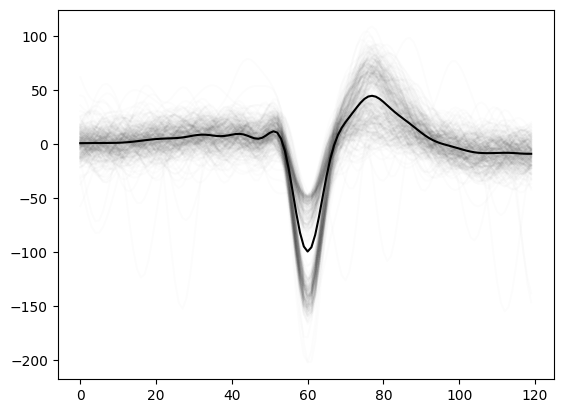

In [221]:
# Plot cross times on one channel
CHAN = 0
N = 300

N_BEFORE = 60
N_AFTER = 60

np.random.seed(231)
##
traces = [] 
for _ in range(N):
    time_ms = np.random.choice(CROSS_TIMES_4[CHAN])
    time = int(time_ms * RECORDING.get_sampling_frequency())
    trace = RECORDING.get_traces_filt(time-N_BEFORE, time+N_AFTER, CHAN).flatten()
    
    plt.plot(trace, color="black", alpha=0.01)
    
    traces.append(trace)
traces = np.stack(traces)
trace_mean = np.mean(traces, axis=0)
plt.plot(trace_mean, color="black")

plt.show()

## Form propagations

In [5]:
# cross_times = CROSS_TIMES_4  # Default threshold
# cross_amps = CROSS_AMPS_4
rms_thresh = 5
chans_rms = CHANS_RMS 
recording = RECORDING

# cross_times_min = CROSS_TIMES_4  # Lower bound (for when creating CCG based on +-2STD)
n_std = 2  # CCG is based on +-n_std*STD when treating electrodes as single

# min_elec_crossings = 1 * 15 * 60

coactivation_window = 0.5

## 
num_elecs = RECORDING.get_num_channels()

In [32]:
# Reformat cross_times into one long array
# all_crossings = []  # [(elec_idx, time, amp)]
# elec_crossings_ind = [[] for _ in range(len(cross_times))]  # ith element for elec idx i. Contains ind in all_crossings for elec idx i's crossings

# pointers = [0] * len(cross_times)
# for t in tqdm(range(sum((len(t) for t in cross_times)))):
#     next_time = np.inf
#     next_amp = None
#     next_elec = None
#     for elec, idx in enumerate(pointers):
#         if idx == len(cross_times[elec]):
#             continue
        
#         time = cross_times[elec][idx]
#         if time < next_time:
#             next_time = time
#             next_amp = cross_amps[elec][idx]
#             next_elec = elec
    
#     all_crossings.append((next_elec, next_time, next_amp))
#     elec_crossings_ind[next_elec].append(t)
#     pointers[next_elec] += 1

  0%|          | 0/4620260 [00:00<?, ?it/s]

100%|██████████| 4620260/4620260 [06:46<00:00, 11367.17it/s]


In [6]:
# np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_4_full/all_crossings.npy", np.array(all_crossings, dtype=object))
# np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_4_full/elec_crossings_ind.npy", np.array(elec_crossings_ind, dtype=object))

all_crossings = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_4_full/all_crossings.npy", allow_pickle=True)  # (elec_idx, cross_time_ms, cross_amp_uv)
elec_crossings_ind = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/thresh_4_full/elec_crossings_ind.npy", allow_pickle=True)  # [(elec's cross times ind in all_crossings)]
first_n_min = 5  # Use only first_n_min of thresh crossings
## Reformat from np.array to lists and tuples for faster indexing and unpacking

if first_n_min is not None:
    end_ms = first_n_min * 60 * 1000
    idx = np.searchsorted(all_crossings[:, 1], end_ms, side="right")
    all_crossings = [tuple(cross) for cross in all_crossings[:idx]]
    elec_crossings_ind = [tuple(i for i in ind if i < idx) for ind in elec_crossings_ind]
    # Sanity check for first_n_min
    assert len(all_crossings) == sum(len(ind) for ind in elec_crossings_ind)
else:
    all_crossings = [tuple(cross) for cross in all_crossings]
    elec_crossings_ind = [tuple(ind) for ind in elec_crossings_ind]  # [(elec's cross times ind in all_crossings)]

In [26]:
def find_elec_cocs(elec_idx,
                   min_amp_ratio=0.9):
    """
    For electrode, return dictionary of
    {
        (elec cross time, elec cross amp): [(other elec idx, other elec cross time, other elec amp)]
    }
    
    If (elec cross time, elec cross amp) not in dictionary, then there was no cooccurrence with another electrode
    
    min_amp_ratio: For all tar_amps for ref_amp, ref_amp / tar_amp has to be at least min_amp_ratio for coocurrence to count as one
    """
    
    coc_dict = {}
    for ref_idx in elec_crossings_ind[elec_idx]:
        _, ref_time, ref_amp = all_crossings[ref_idx]
        cocs = []
        
        # while idx-1 >= 0 and ref_time - all_crossings[idx-1][1] <= coactivation_window:
        #     idx -= 1
        #     cocs.append(all_crossings[idx])
                   
        # while idx+1 < len(all_crossings) and all_crossings[idx+1][1] - ref_time <= coactivation_window:
        #     idx += 1
        #     cocs.append(all_crossings[idx])
        
        idx = ref_idx
        while idx-1 >= 0 and ref_time - all_crossings[idx-1][1] <= coactivation_window:
            idx -= 1
            tar_crossing = all_crossings[idx]
            # if tar_crossing[0] > 12:  # Only allow cocs for close electrodes
            #     continue
            
            if ref_amp / tar_crossing[2] < min_amp_ratio:
                break
            cocs.append(tar_crossing)
        else:           
            idx = ref_idx
            while idx+1 < len(all_crossings) and all_crossings[idx+1][1] - ref_time <= coactivation_window:
                idx += 1
                tar_crossing = all_crossings[idx]
                # if tar_crossing[0] > 12:   # Only allow cocs for close electrodes 
                #     continue
                
                if ref_amp / tar_crossing[2] < min_amp_ratio:
                    break
                cocs.append(tar_crossing)
            else:
                if len(cocs) > 0:
                    coc_dict[(ref_time, ref_amp)] = cocs
                    
    return coc_dict

from multiprocessing import Pool

all_coc_dicts = []
with Pool(processes=12) as pool:
    tasks = range(num_elecs)# [:5]
    for coc_dict in tqdm(pool.imap(find_elec_cocs, tasks), total=len(tasks)):
        all_coc_dicts.append(coc_dict)

  5%|▍         | 12/248 [00:00<00:13, 16.88it/s]

100%|██████████| 248/248 [00:03<00:00, 66.65it/s] 


In [27]:
# for i, coc_dict in enumerate(tqdm(all_coc_dicts)):
#     with open(f"/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/231001/coc_dicts_5min/{i}.pickle", "wb") as f:
#         pickle.dump(coc_dict, f, pickle.HIGHEST_PROTOCOL)

100%|██████████| 248/248 [00:08<00:00, 28.68it/s]


In [8]:
"""  closest_elecs
Index in closest_elecs is electrode index.
Each element is list containing electrode indices sorted by
ascending distance from index electrode (excluding index electrode itself)
"""
all_closest_elecs = []

elec_locs = RECORDING.get_channel_locations()
for elec in range(num_elecs):
    elec_ind = []
    dists = []
    x1, y1 = elec_locs[elec]
    for elec2 in range(RECORDING.get_num_channels()):
        if elec == elec2:
            continue
        x2, y2 = elec_locs[elec2]
        dists.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
        elec_ind.append(elec2)
    order = np.argsort(dists)
    all_closest_elecs.append(np.array(elec_ind)[order])   

In [ ]:
# Test parallel processing
# from joblib import Parallel, delayed
# def test(_):
#     data = np.random.random(1000).reshape((-1, 2))
#     gmm = GaussianMixture(n_components=6, init_params="kmeans", covariance_type="diag")
#     gmm.fit(data)
#     return None
    
# # Full run 
# # all_props = []
# Parallel(n_jobs=20)(delayed(test)(x) for x in tqdm(range(300)))

In [78]:
def pair_elecs(ref_elec_cluster, comp_elec: int, coc_dict: dict,
               min_ref_thresh_crossings=1,
               x_std=2):
    """
    Pair ref elec(s) with tar elec
    
    ref_elec_cluster contains electrodes aleady grouped
        Either ElecCluster or elec_idx
    comp_elec is elec that might be added
    
    min_ref_crossings: in ref_elecs, at least this many elecs need to have rms_thresh*RMS 
    x_std: For cooccurrence of electrodes in cluster, data has to be within x_std*STD of latency and rel_amp
    """
    
    if isinstance(ref_elec_cluster, F.ElecCluster):  # If adding comp_elec to group
        root_elec = ref_elec_cluster.elecs[0]  # First elec is elec with largest amp
        ref_elecs = ref_elec_cluster.elecs_stats  # Stats that cooccurrences between ref elecs need to follow (i.e. mean latency, etc.)
        
    else:  # Creating initial pair
        root_elec = ref_elec_cluster
        ref_elecs = set()
    
    # if len(ref_elecs) == 1 and len(cross_times[root_elec]) < min_elec_crossings:  # Check for when pairing just 2 elecs
    #     return np.array([]), 0
    # if len(cross_times[comp_elec]) < min_elec_crossings:
    #     return np.array([]), 0
            
    coc_matrix = []  # (latency, rel_amp, cross_time_on_root)   
    for (root_time, root_amp), cocs in coc_dict.items():
    # for (root_time, root_amp), cocs in all_coc_dicts[root_elec].items():
        num_ref_crossings = 1  # Count 4RMS crossings  (start with one for root)
        
        num_ref_thresh_crossings = 0  # Only x ref amps need 5RMS crossing
        if root_amp >= rms_thresh * chans_rms[root_elec]:
            num_ref_thresh_crossings = 1
        
        comp_times = []  # For multiple comp_elec crossings cooccuring with same root_elec crossing 
        comp_amps = []   # (this is slower and probably unnecessary than assuming only 1:1 cooccurrence)
        # ref_amps = []  # rel comp amp is comp_amp/mean(ref_amps)
        for tar_elec, tar_time, tar_amp in cocs:
            crosses_thresh = tar_amp >= rms_thresh * chans_rms[tar_elec]
            if tar_elec == comp_elec:
                if crosses_thresh:
                    comp_times.append(tar_time)
                    comp_amps.append(tar_amp)
            elif tar_elec in ref_elecs:
                stats = ref_elecs[tar_elec]
                latency = tar_time - root_time
                rel_amp = tar_amp / root_amp
                if np.abs(latency - stats["latency"]) <= x_std*stats["std_latency"]:
                    if np.abs(rel_amp - stats["rel_amp"]) <= x_std*stats["std_rel_amp"]:
                        num_ref_crossings += 1
                        if crosses_thresh:
                            num_ref_thresh_crossings += 1      
    
        # if num_ref_thresh_crossings >= len(ref_elecs) + 1:                 
        if num_ref_crossings >= len(ref_elecs) + 1 and num_ref_thresh_crossings >= min_ref_thresh_crossings:
        # if num_ref_crossings >= len(ref_elecs) + 1 and num_ref_thresh_crossings >= len(ref_elecs) + 1:
            for comp_time, comp_amp in zip(comp_times, comp_amps):
                coc_matrix.append([comp_time - root_time, comp_amp/root_amp, root_time])  # Need root_time for plotting and debugging

        # Simplified version of finding cooccurrences for testing
        # for tar_elec, tar_time, tar_amp in cocs:
        #     if tar_elec == comp_elec and tar_amp >= rms_thresh * chans_rms[tar_elec] and root_amp >= rms_thresh * chans_rms[root_elec]:
        #         coc_matrix.append([tar_time - root_time, tar_amp/root_amp, root_time])
        #         # break # Can't break since the same tar_elec might cooccur more than one with root_elec
        #     else:
        #         pass

    return np.array(coc_matrix)


def cluster_elec_pair(coc_matrix, elec_pair,
                      k=6, min_cocs=100,
                      max_std_latency=0.167, min_spikes=200,
                      x_std=2):
    """
    Cluster cooccurrences in coc_matrix based on latency and relative amplitude using Gaussian Mixture Model
    
    Parameters:
        coc_matrix:
            From pair_elecs
        elec_pair: [ElecCluster or elec_idx, elex_idx]
            Pair of electrodes used for form coc_matrix
            
        k and min_cocs:
            Cluster goes as follows:
            1. Cluster with k components
            2. If any component has fewer than min_cocs, go back to step 1
            
        max_std_latency:
            After clusters are formed, if any cluster has std_latency greater than this, it and all points
            that make up cluster and discarded

            
    Returns:
        [ElecCluster]
        Gaussian Mixture Model that resulted from clustering
    """

    min_add_p = 60  # #cocs_with_new_elec/#cocs_before_new_elec >= min_add_p to form cluster 

    # global latency_amp_matrix  # For debugging
    
    latency_amp_matrix = coc_matrix[:, 0:2]
    
    # if len(latency_amp_matrix) > gmm_sampling:  # Sample only some cooccurrences to increase speed of making gmm
        
    # if gmm_sampling < latency_amp_matrix.shape[0]:
    #     latency_amp_matrix_sampling = latency_amp_matrix[np.random.choice(latency_amp_matrix.shape[0], gmm_sampling, replace=False)]
    # else:
    #     latency_amp_matrix_sampling = latency_amp_matrix

    # Fit GMM
    while True:       
        # # Form clusters
        gmm = GaussianMixture(n_components=k, init_params="kmeans", covariance_type="diag", tol=1e-6, max_iter=1000, random_state=101)
        gmm.fit(latency_amp_matrix)
        
        # F.plot_gmm(gmm, latency_amp_matrix)
        # plt.show()

        # if elec_pair[1] == 2:
        #     if isinstance(elec_pair[0], F.ElecCluster):
        #         # if elec_pair[0].elecs_stats[1].rel_amp > 1.6 or True:
        #         F.plot_gmm(gmm, latency_amp_matrix)
        #         plt.show()
        
        # region Form ElecClusters with n_components=k (assumes k is correct number of clusters and all clusters are perfect)
        # elec_clusters = []
        # predictions = gmm.predict(latency_amp_matrix)
        # for i, means in enumerate(gmm.means_):
        #     matches = predictions==i
        #     if sum(matches) == 1:  # Prevent warning with ddof=1
        #         continue
            
        #     latencies, rel_amps = latency_amp_matrix[matches, 0:2].T
            
        #     latency = np.mean(latencies)
        #     std_latency = np.std(latencies, ddof=1)
        
        #     rel_amp = np.mean(rel_amps)
        #     std_rel_amp = np.std(rel_amps, ddof=1)

        #     if isinstance(elec_pair[0], F.ElecCluster):
        #         clust = elec_pair[0].add(elec_pair[1], latency, std_latency, rel_amp, std_rel_amp, gmm)
        #     else:
        #         clust = F.ElecCluster.from_pair(elec_pair, latency, std_latency, rel_amp, std_rel_amp, gmm)
        #     clust.spike_train = coc_matrix[predictions==i, 2]
        #     elec_clusters.append(clust)
            
        # F.plot_gmm(gmm, latency_amp_matrix)
        # plt.show()    
        
        # return elec_clusters
        # endregion
        
        predictions = gmm.predict(latency_amp_matrix)
        # Count number of cocs in each cluster
        counts = {}
        for p in predictions:
            if p in counts:
                counts[p] += 1
            else:
                counts[p] = 1       
        
        num_clusters_min_cocs = 0  # Number of clusters with enough coactivations
        for c in counts.values():
            num_clusters_min_cocs += c >= min_cocs
        
        # Check first requirement for forming clusters (enough cocs in each cluster)
        if num_clusters_min_cocs == len(gmm.means_) or k == 1:            
            # return elec_clusters
            elec_clusters = []            
            clusters_latencies = []  # (mean, std) of each cluster
            clusters_rel_amps = []  # (mean, std)  of each cluster
            
            for i, means in enumerate(gmm.means_):
                matches = predictions==i
                if sum(matches) == 1:  # Prevent warning with ddof=1
                    continue
                
                latencies, rel_amps = latency_amp_matrix[matches, 0:2].T
                
                latency = np.mean(latencies)
                std_latency = np.std(latencies, ddof=1)
            
                rel_amp = np.mean(rel_amps)
                std_rel_amp = np.std(rel_amps, ddof=1)

                # IntraGMM merging
                # Check second requirement (latencies and rel_amps are different enough)                
                for comp_latencies, comp_rel_amps in zip(clusters_latencies, clusters_rel_amps):
                    if F.test_mean_std_overlap(latency, std_latency, *comp_latencies, x_std=x_std) and \
                       F.test_mean_std_overlap(rel_amp, std_rel_amp, *comp_rel_amps, x_std=x_std):
                           break
                else:
                    clusters_latencies.append((latency, std_latency))
                    clusters_rel_amps.append((rel_amp, std_rel_amp))
                    
                    if sum(matches) < min_spikes:
                        continue
                    
                    # Form ElecCluster
                    if std_latency <= max_std_latency: # and len(latencies) < min_spikes:  
                        if isinstance(elec_pair[0], F.ElecCluster):
                            if len(latencies) / len(elec_pair[0].spike_train) * 100 >= min_add_p:
                                clust = elec_pair[0].add(elec_pair[1], latency, std_latency, rel_amp, std_rel_amp, gmm)
                                clust.spike_train = coc_matrix[matches, 2]
                                elec_clusters.append(clust)
                        else:
                            clust = F.ElecCluster.from_pair(elec_pair, latency, std_latency, rel_amp, std_rel_amp, gmm, coc_matrix[matches, 2])
                            elec_clusters.append(clust)
                    continue  # Prevents following break which would form new gmm
                    
                break
                    
            else:  # No STD overlap found
                # Todo?: Check that not all clusters triggered max_std_latency clause
                
                # print(elec_pair)
                # F.plot_gmm(gmm, latency_amp_matrix)
                # plt.show()
                
                # assert False
                
                # plt.hist(latency_amp_matrix[:, 1], bins=100)
                # plt.show()
                
                
                
                # # Test pair_elecs and coc_matrix
                # # coc_matrix, mean_ref_amp = pair_elecs(0, 1)
                # # elec_clusters = cluster_elec_pair(coc_matrix, [0, 1])
                # # coc_matrix, mean_ref_amp = pair_elecs(elec_clusters[0], 2)
                # # elec_clusters = cluster_elec_pair(coc_matrix, [elec_clusters[0], 2])

                # # order = np.argsort(-np.array(mean_ref_amps))
                # # idx = order[2000]
                # # print(ind_pairs[idx])
                # # print(mean_ref_amps[idx])

                # # coc_matrix = all_coc_matrix_5[247]
                # # print(ind_pairs[247])

                # plt.hist(coc_matrix[:, 0]*30, bins=91)
                # plt.show()

                # plt.hist(coc_matrix[:, 1], bins=60)
                # plt.show()

                # plt.scatter(coc_matrix[:, 0], coc_matrix[:, 1], alpha=0.02)
                # plt.show()

                # # plt.hist(coc_matrix2[:, 0]*30, bins=91)
                # # plt.show()

                # # plt.hist(coc_matrix2[:, 1], bins=60)
                # # plt.show()

                # # plt.scatter(coc_matrix2[:, 0], coc_matrix2[:, 1], alpha=0.02)
                # # plt.show()
                
                return elec_clusters
            
        k -= 1
            
        
def form_elec_clusters(root_elec_idx,
                       min_spike_overlap_p=60,
                       elec_patience=6,
                       min_cluster_spikes=300,
                       verbose=False,
                       time_frame=None):
    """
    Form all ElecClusters that include root_elec_idx

    Parameters
    ----------
    elec_patience: For each alive root, stop comparing to other electrodes if no new clusters before merging
               after elec_patience comparisons
    min_cluster_spikes:
        If GMM has fewer spikes than this, skip GMM.
        If cluster has fewer spikes than this, discard cluster
        
    time_frame:
        If not None, only use coocurrences between time_frame[0]ms to time_frame[1]ms (inclusive, inclusive)
        If None, use all cooccurrences
    """

    with open(COC_DICT_ROOT / f"{root_elec_idx}.pickle", "rb") as f:
        coc_dict = pickle.load(f)
    
    # time_frame
    if time_frame is not None:
        start_ms, end_ms = time_frame
        new_coc_dict = {}
        for (root_time, root_amp), cocs in coc_dict.items():
            if start_ms <= root_time <= end_ms:
                new_cocs = []
                for elec, time, amp in cocs:
                    if start_ms <= time <= end_ms:
                        new_cocs.append((elec, time, amp))
                if len(new_cocs) > 0:
                    new_coc_dict[(root_time, root_amp)] = new_cocs
        coc_dict = new_coc_dict

    roots = []
    
    elec_patience_counter = 0
    
    if verbose:
        print(f"Starting with elec {root_elec_idx}, loc: {elec_locs[root_elec_idx]}")
        
    # print("FIX THIS SLICING. FORCING EARLY STOPPING AFTER 1 ELEC")
    for comp_elec in all_closest_elecs[root_elec_idx]: # [:2]:          
        if verbose: 
            print(f"\nComparing to elec {comp_elec}, loc: {elec_locs[comp_elec]}, starting with {len(roots)} clusters")
        new_roots = []  # New roots from current iteration (excluding first elec)
        for root in [root_elec_idx] + roots:
            # Grow root
            coc_matrix = pair_elecs(root, comp_elec, coc_dict)
            if len(coc_matrix) > min_cluster_spikes:
                # Store new roots
                elec_clusters = cluster_elec_pair(coc_matrix, [root, comp_elec])            
                new_roots += elec_clusters
        
        if len(new_roots) == 0:
            if verbose:
                print(f"Found 0 new clusters")
            elec_patience_counter += 1
            if elec_patience_counter == elec_patience:
                break
            continue

        # return new_roots
        elec_patience_counter = 0
        
        # Skip merging
        # if comp_elec == 1:
        #     roots = cur_roots
        # else:
        # roots = cur_roots
        # print(f"Found {len(roots)} clusters")
        # if comp_elec == 1:
        #     break
        # continue   
        
        if verbose:
            print(f"{len(new_roots)} new clusters before merging")
        roots += new_roots        
        # Cutting subroots and merging (second iteration --> only merge/cut based on spike overlap)
        dead_roots = set()  # sub roots that were cut or leftover after merging
        for root in roots:
            if root in dead_roots:
                continue
            
            root_elecs = set(root.elecs)
            root_cocs = set(root.spike_train)
            for other_root in roots:
                if root is other_root:
                    continue
                
                if other_root in dead_roots:
                    continue
                
                if root_elecs < set(other_root.elecs):
                    root_cocs.difference_update(other_root.spike_train)
                    if len(root_cocs) < min_cluster_spikes:
                        dead_roots.add(root)
                        break
            else:
                root.spike_train = list(root_cocs)
                                    
        roots = [root for root in roots if root not in dead_roots]
        
        if len(roots) > 15:
            break
        
        if verbose:
            print(f"Found {len(roots)} clusters")

    if verbose:
        print(f"\nFound {len(roots)} clusters")

    return roots
       
       
def set_footprint_stats(self, 
                        num_spikes=500,
                        ms_before=0.5, ms_after=0.5,
                        use_rms_thresh=False, rms_thresh=5, rel_amp_thresh=0.6):
    """
    NOTE: This should be a method of ElecCluster. But RECORDING object cannot be pickeled,
    so if this was a method, parallel processing would be more difficult (would have to 
    input recording path or save filtered recording as .npy).
        :param self: is ElecCluster obj
    
    Extract the mean+-STD latency and relative amplitude of each electrode
    relative to ref_elec and set self.footprint_stats_ to
    [(mean_latency, std_latency, mean_rel_amp, std_rel_amp, amp/chan_rms)] ith element is for elec with index i
    
    NOTE: Handling edge case of waveform extract window going out of bounds of recording duration
    could be slow
    
    Parameters
    ----------
    num_spikes: int or None
        #spikes to sample from spike_train to extract stats
    ms_before, ms_after: float
        For extracting windows for each spike: on each electrode,
        extract [ms_before, ms_after] around spike on self's single root elec
    rms_thresh:
        Elecs with avg amp / chan RMS greater than rms_thresh join self.prop_elecs_
    rel_amp_thresh: 
        Elecs with rel amp greater than rel_amp_thresh join self.prop_elecs_
    """
    
    # Extract waveforms 
    spike_train = self.spike_train
    if num_spikes is not None and num_spikes < len(spike_train):
        spike_train = np.random.choice(spike_train, size=num_spikes, replace=False)

    sf = recording.get_sampling_frequency()
    recording_total_frames = recording.get_total_samples()
    n_before = round(ms_before * sf)
    n_after = round(ms_after * sf)
    num_chans = recording.get_num_channels()
    
    waveforms = np.zeros((len(spike_train), num_chans, n_before + 1 + n_after), dtype="float32")  # (n_wfs, n_chans, n_frames)
    for w, spike in enumerate(spike_train):        
        center_frame = round(spike * sf)
        start_frame = center_frame - n_before
        end_frame = center_frame + n_after + 1
        wf = recording.get_traces_filt(start_frame=max(0, start_frame), 
                                       end_frame=min(end_frame, recording_total_frames))
        if start_frame < 0:
            waveforms[w, :, -start_frame:-start_frame+wf.shape[1]] += wf
        elif end_frame > recording_total_frames:
            waveforms[w, :, :wf.shape[1]] += wf
        else:
            waveforms[w] += wf
        
    first_elec = np.argmin(np.min(np.mean(waveforms, axis=0), axis=1))
        
    # Extract mean+-STD latency and rel amp. Also amp/chan_rms
    wf_latencies = np.argmin(waveforms, axis=2)  # (n_wfs, n_chans) One latency frame for each waveform of each channel
    wf_latencies = (wf_latencies - wf_latencies[:, [first_elec]]) / sf # (wf_latencies - n_before) / sf  # Subtract by first elec's latency since self.spike_train is sometimes a few frames off of spike
    latencies = np.mean(wf_latencies, axis=0)  # There are few 1-frame differences between np.argmin and n_before --> causes latency on ref_elec to not exactly be 0
    std_latencies = np.std(wf_latencies, axis=0, ddof=1)
        
    # Extracting amplitudes at mean latency of each elec is most accurate method because it best reflects the results of the mean waveform footprint
    latencies_frames = np.rint(latencies * sf + n_before).astype(int)  # (n_chans,)
    wf_amps = -waveforms[:, range(num_chans), latencies_frames]  # (n_wfs, n_chans), - so amps are positive
    
    wf_amps_mean = np.mean(wf_amps, axis=0)  # (n_chans,)
    top_elecs = np.argsort(wf_amps_mean)[-5:]
    
    wf_rel_amps = wf_amps / np.mean(wf_amps[:, top_elecs], keepdims=True) # wf_amps[:, self.elecs[[0]]]  
    rel_amps = np.mean(wf_rel_amps, axis=0)
    std_rel_amps = np.std(wf_rel_amps, axis=0, ddof=1)

    wf_amps_rms = wf_amps_mean / chans_rms  # Extracting amps at mean latency

    self.footprint_stats_ = np.vstack([latencies, std_latencies, rel_amps, std_rel_amps, wf_amps_rms]).T  # (n_chans, 5)
    
    # Electrodes used for merging
    self.prop_elecs_ = []
    elecs_sorted = np.argsort(-rel_amps)  # - to sort in descending order
    if use_rms_thresh:
        for elec in elecs_sorted:
            if wf_amps_rms[elec] >= rms_thresh and rel_amps[elec] >= rel_amp_thresh:
                self.prop_elecs_.append(elec)
            else:
                break        
    else:
        for elec in elecs_sorted:
            if rel_amps[elec] >= rel_amp_thresh:
                self.prop_elecs_.append(elec)
            else:
                break
                
    # footprint_stats = set_footprint_stats(elec_clusters[1])
    # elecs = [0, 2, 1, 4, 3, 6]
    # for elec, stats in zip(elecs, footprint_stats[elecs]):
    #     print(elec, [round(s, 2) for s in stats])

    # Extract stats
    # for root in roots:
    #     set_footprint_stats(root)
        
       
# OLD, merge in descending order of most number of spikes
# def merge_roots(roots, 
#                 min_elec_overlap_p=50, 
#                 min_stat_overlap_p=75, x_std_merge=1,
#                 verbose=False):
#     """
#     Final merge after roots are fully formed
#     """
#     # from copy import deepcopy
#     # roots = deepcopy(roots)
    
#     for root in roots:
#         if not hasattr(root, "footprint_stats_"):
#             set_footprint_stats(root)
    
#     # Sort props from most to least spikes
#     nums_spikes = [-len(root.spike_train) for root in roots]
#     order = np.argsort(nums_spikes)

#     # For each root, merge with existing prop unit or form new prop unit
#     props = [roots[order[0]]]
#     props_root_ind = [[order[0]]]  # Root ind in each prop
#     if verbose:
#         print(f"Formed root {order[0]} into prop 0")
#     for idx in order[1:]:
#         root = roots[idx]
#         root_elecs = set(root.prop_elecs_)
#         # Find which prop (if any) root should merge with
#         for p, prop in enumerate(props):
#             # Check if can merge
#             # 1) Elec overlap
#             elec_overlaps = root_elecs.intersection(prop.prop_elecs_)
#             if len(elec_overlaps) / (len(root.prop_elecs_) + len(prop.prop_elecs_) - len(elec_overlaps)) < min_elec_overlap_p / 100:
#                 continue  # Not enough elec overlap to merge
            
#             # 2) Overlapping footprint_stats_
#             num_stat_overlaps = 0
#             for elec in elec_overlaps:
#                 if F.test_mean_std_overlap(*root.footprint_stats_[elec, :2], *prop.footprint_stats_[elec, :2], x_std_merge) and \
#                    F.test_mean_std_overlap(*root.footprint_stats_[elec, 2:4], *prop.footprint_stats_[elec, 2:4], x_std_merge):
#                     num_stat_overlaps += 1
#             if num_stat_overlaps / len(elec_overlaps) >= min_stat_overlap_p / 100:
#                 # Update spike train
#                 spike_train = set(root.spike_train).union(prop.spike_train)
                
#                 # Update stats
#                 footprint_stats = np.zeros_like(root.footprint_stats_)
#                 ## Update means
#                 total_spikes = len(root.spike_train) + len(prop.spike_train)
#                 root_ratio = len(root.spike_train) / total_spikes
#                 prop_ratio = len(prop.spike_train) / total_spikes
#                 ### Latency
#                 footprint_stats[:, 0] = root.footprint_stats_[:, 0] * root_ratio + prop.footprint_stats_[:, 0] * prop_ratio
#                 ### Rel amp
#                 footprint_stats[:, 2] = root.footprint_stats_[:, 2] * root_ratio + prop.footprint_stats_[:, 2] * prop_ratio
                
#                 ## Update STD  https://math.stackexchange.com/a/2971563
#                 n = len(root.spike_train)
#                 m = len(prop.spike_train)
#                 for i in [0, 2]:  # 0=latency, 2=rel amp
#                     x = root.footprint_stats_[:, i]
#                     sx = np.square(root.footprint_stats_[:, i+1])
                    
#                     y = prop.footprint_stats_[:, i]
#                     sy = np.square(prop.footprint_stats_[:, i+1])
                    
#                     sz = ((n-1)*sx + (m-1)*sy) / (n + m - 1)
#                     sz += n*m*(x-y)**2 / ((n+m)*(n+m-1))
                
#                     footprint_stats[:, i+1] = np.sqrt(sz)
                
#                 prop.spike_train = spike_train
#                 prop.footprint_stats_ = footprint_stats
                
#                 if verbose:
#                     print(f"Merged root {idx} with prop {p} {props_root_ind[p]}")
#                     props_root_ind[p].append(idx)
                
#                 break  # Don't merge root with another prop
            
#         else:  # New prop
#             props.append(root)
#             props_root_ind.append([idx])
#             if verbose:
#                 print(f"Formed root {idx} into prop {len(props)-1}")
    
#     if verbose:        
#         print(f"\nFormed {len(props)} props")
#         for p, root_ind in enumerate(props_root_ind):
#             print(f"prop {p}: {root_ind}")
    
#     for prop in props:
#         prop.spike_train = np.sort(list(prop.spike_train))
    
#     return props


class MergeData:
    """Store data about the best merge"""
    def __init__(self, root_a, root_b,
                 elec_overlap_n, elec_overlap_p, 
                 stat_overlap_n, stat_overlap_p) -> None:
        self.root_a = root_a
        self.root_b = root_b
        
        self.elec_overlap_n = elec_overlap_n
        self.elec_overlap_p = elec_overlap_p
        self.stat_overlap_n = stat_overlap_n
        self.stat_overlap_p = stat_overlap_p
        
    def can_merge(self, 
                  min_elec_overlap_n, min_elec_overlap_p,
                  min_stat_overlap_n, min_stat_overlap_p):
        if self.elec_overlap_n < min_elec_overlap_n:
            # print(0)
            return False
        if self.elec_overlap_p < min_elec_overlap_p:
            # print(1)
            return False
        if self.stat_overlap_n < min_stat_overlap_n:
            # print(2)
            return False
        if self.stat_overlap_p < min_stat_overlap_p:
            # print(3)
            return False
        return True
        
    def __lt__(self, other):
        """
        Determine if self is a worse merge than other
        How to determine this:
            elec_overlap_n and elec_overlap_p is mainly just so that there is enough electrodes to compare the stats.
            Compare in following order (continue to next if they are equal)
                1. stat_overlap_p
                2. stat_overlap_n
                3. elec_overlap_p
                4. elec_overlap_n
        """
        
        if self.stat_overlap_p < other.stat_overlap_p:
            return True
        elif self.stat_overlap_p > other.stat_overlap_p:
            return False
        
        if self.stat_overlap_n < other.stat_overlap_n:
            return True
        elif self.stat_overlap_n > other.stat_overlap_n:
            return False
        
        if self.elec_overlap_p < other.elec_overlap_p:
            return True
        elif self.elec_overlap_p > other.elec_overlap_p:
            return False
        
        if self.elec_overlap_n < other.elec_overlap_n:
            return True
        elif self.elec_overlap_n > other.elec_overlap_n:
            return False
        
        return False  # self and other are the same level of merging


def score_merge(root_a, root_b, x_std_merge) -> MergeData:
    # Elec overlap
    elec_overlaps = set(root_a.prop_elecs_).intersection(root_b.prop_elecs_)
    stat_overlap_n = 0
    for elec in elec_overlaps:
        if F.test_mean_std_overlap(*root_a.footprint_stats_[elec, :2], *root_b.footprint_stats_[elec, :2], x_std_merge) and \
           F.test_mean_std_overlap(*root_a.footprint_stats_[elec, 2:4], *root_b.footprint_stats_[elec, 2:4], x_std_merge):
               stat_overlap_n += 1

    elec_overlaps_n = len(elec_overlaps)
    return MergeData(
        root_a, root_b,
        elec_overlaps_n, elec_overlaps_n / (len(root_a.prop_elecs_) + len(root_b.prop_elecs_) - elec_overlaps_n) * 100,
        stat_overlap_n, stat_overlap_n / elec_overlaps_n * 100 if elec_overlaps_n > 0 else 0  # Prevent divide by 0 error
    )


def merge_roots(roots, 
                min_elec_overlap_n=0, min_elec_overlap_p=50, 
                min_stat_overlap_n=0, min_stat_overlap_p=75, x_std_merge=1,
                verbose=False):
    """
    Final merge after roots are fully formed
    
    Pseudocode:
        1. Find pair with most overlap (best score_merge)
        2. Merge pair
        3. Repeat step 1 until no pair has enough overlap to merge
    """
    
    roots = deepcopy(roots)
    for root in roots:
        if not hasattr(root, "footprint_stats_"):
            set_footprint_stats(root)
    
    if verbose:
        root_to_idx = {root: idx for idx, root in enumerate(roots)}
    dead_roots = set()  # Store roots that have been merged into another in this set instead of removing them from roots
    while True:
        best_merge = None
        # Find pair with most overlap (best score_merge)        
        for idx_a in range(len(roots)):
            root_a = roots[idx_a]
            if root_a in dead_roots:
                continue
            for idx_b in range(idx_a+1, len(roots)):
                root_b = roots[idx_b]
                if root_b in dead_roots:
                    continue
                cur_merge = score_merge(root_a, root_b, x_std_merge)
                if not cur_merge.can_merge(min_elec_overlap_n, min_elec_overlap_p, min_stat_overlap_n, min_stat_overlap_p):
                    continue
                
                if best_merge is None or best_merge < cur_merge:
                    best_merge = cur_merge
        
        if best_merge is None:
            break

        # merge roots in best_merge
        root_a, root_b = best_merge.root_a, best_merge.root_b
        # Update spike train
        spike_train = set(root_a.spike_train).union(root_b.spike_train)
        
        # Update stats
        footprint_stats = np.zeros_like(root_a.footprint_stats_)
        ## Update means
        total_spikes = len(root_a.spike_train) + len(root_b.spike_train)
        root_a_ratio = len(root_a.spike_train) / total_spikes
        root_b_ratio = len(root_b.spike_train) / total_spikes
        ### Latency
        footprint_stats[:, 0] = root_a.footprint_stats_[:, 0] * root_a_ratio + root_b.footprint_stats_[:, 0] * root_b_ratio
        ### Rel amp
        footprint_stats[:, 2] = root_a.footprint_stats_[:, 2] * root_a_ratio + root_b.footprint_stats_[:, 2] * root_b_ratio
        
        ## Update STD  https://math.stackexchange.com/a/2971563
        n = len(root_a.spike_train)
        m = len(root_b.spike_train)
        for i in [0, 2]:  # 0=latency, 2=rel amp
            x = root_a.footprint_stats_[:, i]
            sx = np.square(root_a.footprint_stats_[:, i+1])
            
            y = root_b.footprint_stats_[:, i]
            sy = np.square(root_b.footprint_stats_[:, i+1])
            
            sz = ((n-1)*sx + (m-1)*sy) / (n + m - 1)
            sz += n*m*(x-y)**2 / ((n+m)*(n+m-1))
        
            footprint_stats[:, i+1] = np.sqrt(sz)
        
        root_a.spike_train = spike_train
        root_a.footprint_stats_ = footprint_stats
        dead_roots.add(root_b)
        
        if verbose:          
            message = f"Merged {root_to_idx[root_a]}"
            if hasattr(root_a, "merge_history"):
                message += f"+{root_a.merge_history}"
                root_a.merge_history.append(root_to_idx[root_b])                
            else:
                root_a.merge_history = [root_to_idx[root_b]]
            
            message += f" with {root_to_idx[root_b]}"
            if hasattr(root_b, "merge_history"):
                root_a.merge_history += root_b.merge_history
                message += f"+{root_b.merge_history}"
            print(message)
        
    n_og_roots = len(roots)
    roots = [root for root in roots if root not in dead_roots]
    if verbose:        
        print(f"\nFormed {n_og_roots - len(dead_roots)} props")
        p = 0
        for p, root in enumerate(roots):
            message = f"prop {p}: {root_to_idx[root]}"
            if hasattr(root, "merge_history"):
                message += f",{root.merge_history}"
            print(message)
            p += 1
        print(f"Formed {n_og_roots - len(dead_roots)} props")  # Reprint this because jupyter notebook cuts of middle of long outputs
    
    for root in roots:
        root.spike_train = np.sort(list(root.spike_train))
    
    return roots


# Test forming clusters
# roots = form_elec_clusters(0, verbose=True, time_frame=(0, 5*60*1000))
# props = merge_roots(roots, verbose=True)

# # Plot clusters
# elec_clusters = roots
# units = []
# def get_unit_templates(cluster_idx):
#     cluster = elec_clusters[cluster_idx]
#     unit = Unit(idx=cluster_idx, spike_train=cluster.spike_train, channel_idx=cluster.elecs[0], recording=RECORDING)
#     return cluster_idx, unit.get_templates()

# with Pool(processes=20) as pool:
#     tasks = range(len(elec_clusters))
#     for cluster_idx, templates in tqdm(pool.imap(get_unit_templates, tasks), total=len(tasks)):
#         cluster = elec_clusters[cluster_idx]
#         unit = Unit(idx=cluster_idx, spike_train=cluster.spike_train, channel_idx=cluster.elecs[0], recording=RECORDING)
#         unit.templates = templates
#         units.append(unit)
# # Plot
# kwargs = None
# for i, unit in enumerate(units):
#     if kwargs is None:
#         kwargs = unit.plot(chans_rms=CHANS_RMS)
#     else:
#         kwargs = unit.plot(**kwargs) 
#     plt.show()

In [ ]:
# Plot clusters
elec_clusters = roots
units = []
def get_unit_templates(cluster_idx):
    cluster = elec_clusters[cluster_idx]
    unit = Unit(idx=cluster_idx, spike_train=cluster.spike_train, channel_idx=cluster.elecs[0], recording=RECORDING)
    return cluster_idx, unit.get_templates()

with Pool(processes=20) as pool:
    tasks = range(len(elec_clusters))
    for cluster_idx, templates in tqdm(pool.imap(get_unit_templates, tasks), total=len(tasks)):
        cluster = elec_clusters[cluster_idx]
        unit = Unit(idx=cluster_idx, spike_train=cluster.spike_train, channel_idx=cluster.elecs[0], recording=RECORDING)
        unit.templates = templates
        units.append(unit)
# Plot
kwargs = None
for i, unit in enumerate(units):
    if kwargs is None:
        kwargs = unit.plot(chans_rms=CHANS_RMS)
    else:
        kwargs = unit.plot(**kwargs) 
    plt.show()

In [38]:
# Create all roots
# GaussianMixture.fit does not work with library mulitprocessing

def form_roots(root_elec):
    roots = form_elec_clusters(root_elec, time_frame=(0, 5*60*1000))
    return roots
    
all_roots = []
tasks = range(0, num_elecs)   
all_roots += Parallel(n_jobs=20, verbose=1000, batch_size=1, max_nbytes=None)(
    delayed(form_roots)(root_elec) for root_elec in tasks
    )
    
# Total number of roots before final merge
print(sum(len(r) for r in all_roots))

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done   3 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done   4 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done   5 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done   6 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done   7 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done   8 tasks      | elapsed:    3.5s
[Parallel(n_jobs=20)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done  12 tasks      | elapsed:    5.6s
[Parallel(n_jobs=20)]: Done  13 tasks      | elapsed:    5.8s
[Parallel(n_jobs=20)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=20)]: Done  15 tasks      | elapsed:    6.8s
[Parallel(n_jobs=20)]: Done  16 tasks      | elapsed:    6.9s
[Paralle

In [39]:
# Set footprint stats for each elec cluster
def get_roots_with_footprints(roots):
    new_roots = []
    for root in roots:
        set_footprint_stats(root)
        new_roots.append(root)
    return new_roots

all_roots_with_footprints = []
with Pool(processes=20) as pool:
    for root in tqdm(pool.imap(get_roots_with_footprints, all_roots), total=len(all_roots)):
        all_roots_with_footprints.append(root)
        
# Initially, tqdm says this will take a while, but it only takes a few minutes.

100%|██████████| 248/248 [02:31<00:00,  1.63it/s]


In [85]:
# Get unit templates for plotting (only needed for manual testing)

elec_clusters = all_roots  # test2  # all_props[:10]
units = []

def get_unit_templates(cluster_idx):
    cluster = elec_clusters[cluster_idx]
    unit = Unit(idx=cluster_idx, spike_train=cluster.spike_train, channel_idx=cluster.elecs[0], recording=RECORDING)
    return cluster_idx, unit.get_templates()

with Pool(processes=20) as pool:
    tasks = range(len(elec_clusters))
    for cluster_idx, templates in tqdm(pool.imap(get_unit_templates, tasks), total=len(tasks)):
        cluster = elec_clusters[cluster_idx]
        unit = Unit(idx=cluster_idx, spike_train=cluster.spike_train, channel_idx=cluster.elecs[0], recording=RECORDING)
        unit.templates = templates
        units.append(unit)
        
# region Get units without parallel processing
# units = []
# for i, cluster in enumerate(elec_clusters[1:]):
#     unit = Unit(idx=i+1, spike_train=cluster.spike_train, channel_idx=0, recording=RECORDING)
#     unit.set_templates()
#     # wfs = []
#     # for _ in range(300):
#     #     wfs.append(unit.get_waveforms())
#     # wfs = np.array(wfs).transpose(1, 0, 2)
    
#     units.append(unit)
# endregion

# Plot
# kwargs = None
# for i, unit in enumerate(units):
#     print(len(unit))
#     # display(elec_clusters[i].df)
    
#     if kwargs is None:
#         kwargs = unit.plot(chans_rms=CHANS_RMS)
#     else:
#         unit.plot(**kwargs)
    
#     plt.show()

100%|██████████| 242/242 [01:21<00:00,  2.99it/s]


### Improve merging by looking at roots on each electrode

In [14]:
# Need to have task be a single unit since elecs have different number of roots (task cannot be all roots on an elec)
def get_unit(task):
    elec, idx, root = task
    
    unit = Unit(idx=idx, spike_train=root.spike_train, channel_idx=root.elecs[0], recording=RECORDING)    
    unit.set_templates()
    unit.recording = None  # h5py objects cannot be pickled
    return elec, unit

elecs_units = [[] for _ in range(len(all_roots_with_footprints))]
with Pool(processes=20) as pool:
    tasks = []
    for e, roots in enumerate(all_roots_with_footprints):
        for i, root in enumerate(roots):
            tasks.append((e, i, root))
            
    for elec, unit in tqdm(pool.imap(get_unit, tasks), total=len(tasks)):
        unit.recording = RECORDING
        elecs_units[elec].append(unit)        

100%|██████████| 299/299 [01:40<00:00,  2.98it/s]


In [ ]:
for i, unit in enumerate(units[:5]):
    print(len(unit))
    # display(elec_clusters[i].df)
    unit.plot(chans_rms=CHANS_RMS)
    # if kwargs is None:
    #     kwargs = unit.plot(chans_rms=CHANS_RMS)
    # else:
    #     unit.plot(**kwargs)
    
    plt.show()

In [17]:
elec_ind_with_roots = [elec for elec in range(len(all_roots_with_footprints)) if len(all_roots_with_footprints[elec]) >= 1]
print(elec_ind_with_roots)

[0, 3, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 36, 40, 41, 42, 44, 46, 47, 49, 50, 51, 52, 53, 73, 75, 77, 79, 80, 81, 82, 83, 86, 87, 90, 95, 97, 98, 121, 123, 124, 132, 135, 137, 139, 140, 141, 143, 144, 145, 146, 147, 149, 150, 151, 152, 154, 155, 156, 158, 159, 160, 162, 199, 202, 203, 204, 205, 206, 207, 208, 209, 211, 215, 217, 218, 221, 227, 238]





Elec: 75, loc=[  11. 1020.]


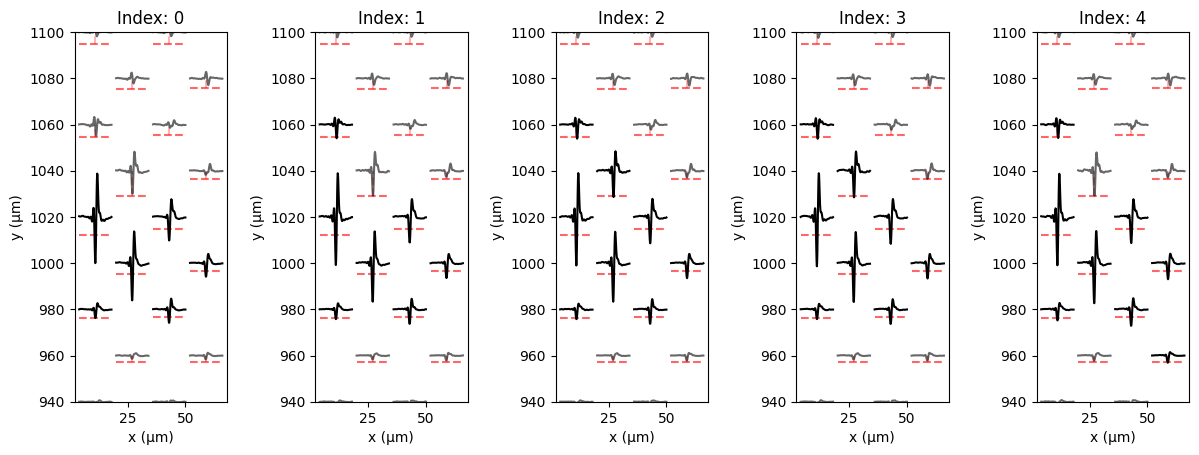

#spikes: [394, 1680, 1389, 1030, 458]

Formed root 1 into prop 0
Merged root 2 with prop 0 [1]
Merged root 3 with prop 0 [1, 2]
Merged root 4 with prop 0 [1, 2, 3]
Merged root 0 with prop 0 [1, 2, 3, 4]

Formed 1 props
prop 0: [1, 2, 3, 4, 0]
#spikes: [2441]


75 [-0.0051, 0.0502, 1.619, 0.1636, 12.5126]
73 [-0.0107, 0.0352, 1.3069, 0.1669, 16.4663]
74 [-0.0069, 0.0472, 0.8254, 0.1214, 10.1385]
77 [0.0144, 0.0752, 0.7733, 0.1594, 4.4101]

75 [0.0, 0.0, 1.5813, 0.102, 13.1406]
73 [-0.015, 0.0166, 1.2572, 0.0867, 17.0314]
74 [-0.01, 0.0153, 0.8417, 0.0845, 11.1168]
77 [0.0242, 0.0263, 0.8297, 0.0987, 5.0877]

75 [-0.0001, 0.0021, 1.5778, 0.1011, 13.2675]
73 [-0.0147, 0.0166, 1.2459, 0.0903, 17.0789]
77 [0.0233, 0.0153, 0.8457, 0.0874, 5.2477]
74 [-0.0117, 0.0159, 0.8453, 0.083, 11.2975]

75 [0.0, 0.0, 1.5692, 0.1029, 13.4034]
73 [-0.0155, 0.0166, 1.2364, 0.0952, 17.2156]
74 [-0.0113, 0.0158, 0.8565, 0.0848, 11.627]
77 [0.0226, 0.0157, 0.8457, 0.1033, 5.3299]

75 [0.0, 0.0, 1.5528, 0.1171

In [28]:
# For each electrode, look at roots to see how to improve merging
# elec_idx = elec_ind_with_roots[7]
##
for elec_idx in elec_ind_with_roots[38:39]:
    print("\n\n")
    roots = all_roots_with_footprints[elec_idx]
    units = elecs_units[elec_idx]

    print(f"Elec: {elec_idx}, loc={RECORDING.get_channel_locations()[elec_idx]}")
    fig, axes = plt.subplots(1, len(roots), figsize=(3*len(roots), 4.8))
    axes = np.atleast_1d(axes)

    kwargs = None
    for a, unit in enumerate(units):
        if kwargs is None:
            kwargs = unit.plot(chans_rms=CHANS_RMS, axis=axes[a])
        else:
            unit.plot(**kwargs, axis=axes[a])
    plt.show()
    
    print(f"#spikes: {[len(unit.spike_train) for unit in units]}\n")
        
    merges = merge_roots(deepcopy(roots), verbose=True)
    print(f"#spikes: {[len(merge.spike_train) for merge in merges]}\n")
    
    for root in roots:
        print()
        for elec in root.prop_elecs_:
            print(elec, [round(s, 4) for s in root.footprint_stats_[elec]])

In [19]:
for elec in merges[0].prop_elecs_:
    print(elec, [round(s, 4) for s in merges[0].footprint_stats_[elec]])

75 [-0.0008, 0.0202, 1.5791, 0.1182, 0.0]
73 [-0.0145, 0.0208, 1.2618, 0.1102, 0.0]
74 [-0.0101, 0.024, 0.8432, 0.0957, 0.0]
77 [0.0217, 0.0351, 0.8232, 0.1167, 0.0]


In [82]:
for root in roots:
    print()
    print(len(root.spike_train))
    print(root.prop_elecs_)
    for elec in root.prop_elecs_:
        print(elec, [round(s, 2) for s in root.footprint_stats_[elec]])


526
[3, 6, 4, 5, 8, 2]
3 [0.0, 0.0, 1.65, 0.13, 24.49]
6 [0.09, 0.02, 1.13, 0.08, 16.04]
4 [0.08, 0.02, 0.87, 0.08, 13.98]
5 [0.03, 0.02, 0.71, 0.07, 10.86]
8 [0.14, 0.08, 0.64, 0.14, 7.15]
2 [0.06, 0.02, 0.64, 0.08, 10.51]

595
[3, 6, 4, 5, 8, 2]
3 [0.0, 0.0, 1.64, 0.13, 24.45]
6 [0.09, 0.02, 1.13, 0.1, 16.16]
4 [0.08, 0.02, 0.87, 0.1, 14.07]
5 [0.03, 0.02, 0.71, 0.09, 10.93]
8 [0.14, 0.08, 0.64, 0.15, 7.26]
2 [0.06, 0.02, 0.64, 0.1, 10.55]


In [81]:
len(set(roots[0].spike_train).intersection(roots[1].spike_train))

525

In [ ]:
for i, unit in enumerate(units):
    print(len(unit))
    # display(elec_clusters[i].df)
    
    kwargs = unit.plot(chans_rms=CHANS_RMS)

    plt.show()

### Merge

In [81]:
all_props = []
for roots in tqdm(all_roots_with_footprints):
    if len(roots) <= 1:
        all_props += roots
    else:
        all_props += merge_roots(roots)

# Total number of propagations
print(len(all_props))

  0%|          | 0/248 [00:00<?, ?it/s]

100%|██████████| 248/248 [00:00<00:00, 447.64it/s]

103


In [79]:
new_props = merge_roots(all_props, verbose=True)

Merged 89 with 90
Merged 85 with 91
Merged 85+[91] with 89+[90]
Merged 81 with 82
Merged 72 with 74
Merged 85+[91, 89, 90] with 87
Merged 55 with 57
Merged 97 with 98
Merged 20 with 22
Merged 45 with 47
Merged 45+[47] with 46
Merged 59 with 60
Merged 68 with 71
Merged 32 with 34
Merged 40 with 41
Merged 4 with 6
Merged 17 with 19
Merged 86 with 88
Merged 7 with 8
Merged 10 with 12
Merged 93 with 96
Merged 59+[60] with 61
Merged 78 with 80
Merged 10+[12] with 13
Merged 10+[12, 13] with 11
Merged 63 with 65
Merged 93+[96] with 95
Merged 55+[57] with 56
Merged 25 with 26
Merged 24 with 25+[26]
Merged 73 with 75
Merged 37 with 38
Merged 35 with 37+[38]
Merged 35+[37, 38] with 36
Merged 85+[91, 89, 90, 87] with 86+[88]
Merged 77 with 79
Merged 28 with 29
Merged 21 with 24+[25, 26]
Merged 81+[82] with 83

Formed 64 props
prop 0: 0
prop 1: 1
prop 2: 2
prop 3: 3
prop 4: 4,[6]
prop 5: 5
prop 6: 7,[8]
prop 7: 9
prop 8: 10,[12, 13, 11]
prop 9: 14
prop 10: 15
prop 11: 16
prop 12: 17,[19]
prop 13: 

In [ ]:
# Look at footprints of units that are merged
for idx in [85, 91, 89, 90]:
    prop = all_props[idx]
    unit = Unit(idx, prop.spike_train, prop.prop_elecs_[0], RECORDING)
    unit.plot(chans_rms=CHANS_RMS)
    plt.show()

In [ ]:
# Get units of props for plotting (only needed for manual testing)

elec_clusters = all_props
units = []

def get_unit_templates(cluster_idx):
    cluster = elec_clusters[cluster_idx]
    unit = Unit(idx=cluster_idx, spike_train=cluster.spike_train, channel_idx=cluster.elecs[0], recording=RECORDING)
    return cluster_idx, unit.get_templates()

with Pool(processes=20) as pool:
    tasks = range(len(elec_clusters))
    for cluster_idx, templates in tqdm(pool.imap(get_unit_templates, tasks), total=len(tasks)):
        cluster = elec_clusters[cluster_idx]
        unit = Unit(idx=cluster_idx, spike_train=cluster.spike_train, channel_idx=cluster.elecs[0], recording=RECORDING)
        unit.templates = templates
        units.append(unit)

# Plot
kwargs = None
for i, unit in enumerate(units):
    unit.plot(chans_rms=CHANS_RMS)    
    plt.show()

#### Additional testing

In [338]:
# # Convert ElecClusters in all_props to F.Propagations --> UNFINISHED
# prop_rms_thresh = 4.5  # Elecs need to cross this to be a part of the final propagation

# import pandas as pd

# merged_propagations = []
# for prop in all_props:
#     # Get elecs that cross 4.5RMS
#     elecs_sorted = np.argsort(-prop.footprint_stats_[:, 4])  # - to sort in descending order
#     dataframe = []
#     for elec in elecs_sorted:
#         if prop.footprint_stats_[elec, 4] >= prop_rms_thresh:
#             dataframe.append((elec, prop.footprint_stats[elec, 0], 100, 1))
#         else:
#             break
#     dataframe = pd.DataFrame(dataframe, columns=["ID", "latency", "cooccurrences", "ccg_ratio"])
#     dataframe = dataframe.astype({"ID": int, "latency": float, "cooccurrences": int, "ccg_ratio": float})
    
#     propagation = F.Propagation(dataframe=dataframe, recording=RECORDING)
#     propagation.mean_amps_all = prop.footprint_stats_[:, 4] * CHANS_RMS
#     merged_propagations.append(propagation)

# Convert Units in units to F.Propagations
prop_rms_thresh = 4.5  # Elecs need to cross this to be a part of the final propagation

import pandas as pd

merged_propagations = []
for prop in all_props:
    # Get elecs that cross 4.5RMS
    elecs_sorted = np.argsort(-prop.footprint_stats_[:, 4])  # - to sort in descending order
    dataframe = []
    for elec in elecs_sorted:
        if prop.footprint_stats_[elec, 4] >= prop_rms_thresh:
            dataframe.append((elec, prop.footprint_stats[elec, 0], 100, 1))
        else:
            break
    dataframe = pd.DataFrame(dataframe, columns=["ID", "latency", "cooccurrences", "ccg_ratio"])
    dataframe = dataframe.astype({"ID": int, "latency": float, "cooccurrences": int, "ccg_ratio": float})
    
    propagation = F.Propagation(dataframe=dataframe, recording=RECORDING)
    propagation.mean_amps_all = prop.footprint_stats_[:, 4] * CHANS_RMS
    merged_propagations.append(propagation)

AttributeError: 'ElecCluster' object has no attribute 'footprint_stats_'

In [634]:
# for elec in clusteri_elecs:
#     # Check latency and rel amp overlap
#     print(F.test_mean_std_overlap(*clusteri.elecs_stats[elec][:2], *clusterj.elecs_stats[elec][:2], 1),
#           F.test_mean_std_overlap(*clusteri.elecs_stats[elec][2:4], *clusterj.elecs_stats[elec][2:4], 1))

True True
False False
True True


2619
363
178


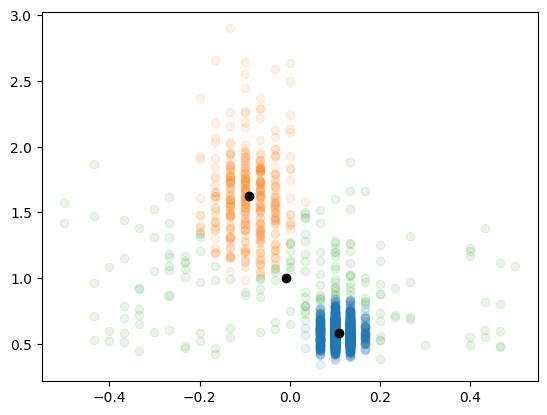

In [ ]:
# latency_amp_matrix = coc_matrix[:, [0, 1]]
# F.plot_gmm(elec_clusters[1].gmms[-1], latency_amp_matrix)
# plt.show()

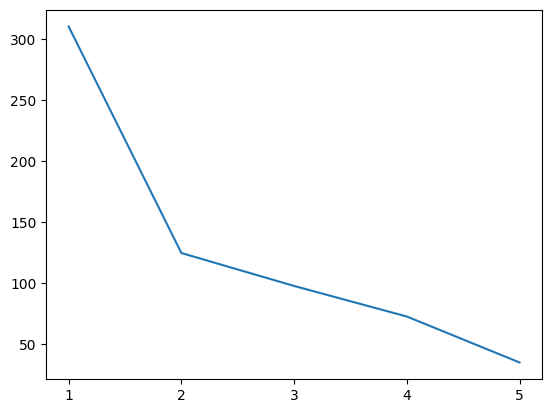

In [ ]:
# Plot within-cluster sum of squares vs num clusters
# from sklearn.metrics import pairwise_distances_argmin_min
# k_values = range(1, 6)
# all_wcss = []

# for k in k_values:
#     gmm = GaussianMixture(n_components=k, init_params="kmeans", covariance_type="diag", tol=1e-9, max_iter=1000, random_state=101).fit(latency_amp_matrix)
#     cluster_labels = gmm.predict(latency_amp_matrix)
#     distances_to_centers = pairwise_distances_argmin_min(latency_amp_matrix, gmm.means_)[1]
#     wcss = np.sum(distances_to_centers ** 2)
#     all_wcss.append(wcss)

# plt.plot(k_values, all_wcss)
# plt.xticks(k_values)
# plt.show()

## Detect spikes

In [82]:
# Reset footprint_stats_ and prop_elecs_ after merging
def get_prop_with_footprint(prop):
    set_footprint_stats(prop, use_rms_thresh=True)
    return prop

all_props_with_footprints = []
with Pool(processes=20) as pool:
    for prop in tqdm(pool.imap(get_prop_with_footprint, all_props), total=len(all_props)):
        all_props_with_footprints.append(prop)
all_props = all_props_with_footprints

100%|██████████| 103/103 [00:49<00:00,  2.07it/s]


In [188]:
def detect_spikes(prop, 
                  min_coc_p=50, min_coc_n=2, rms_thresh=5, x_std=2,
                  isi_viol=1.5,
                  time_frame=None):
    """
    Parameters
    ----------
    time_frame:
        If not None, only use coocurrences between time_frame[0]ms to time_frame[1]ms (inclusive, inclusive)
        If None, use all cooccurrences
    """
    
    spike_train = set()
    
    prop_elecs = set(prop.prop_elecs_)
    for ref_elec in prop_elecs:
        with open(COC_DICT_ROOT / f"{ref_elec}.pickle", "rb") as f:
            coc_dict = pickle.load(f)
            
        # time_frame
        if time_frame is not None:
            start_ms, end_ms = time_frame
            new_coc_dict = {}
            for (root_time, root_amp), cocs in coc_dict.items():
                if start_ms <= root_time <= end_ms:
                    new_cocs = []
                    for elec, time, amp in cocs:
                        if start_ms <= time <= end_ms:
                            new_cocs.append((elec, time, amp))
                    if len(new_cocs) > 0:
                        new_coc_dict[(root_time, root_amp)] = new_cocs
            coc_dict = new_coc_dict
        
        elec_stats = prop.footprint_stats_   
        min_num_cocs = max(min_coc_p / 100 * len(prop.prop_elecs_), min_coc_n)
        for (time, amp), crossings in coc_dict.items():                       
            prop_crossings = [(ref_elec, time, amp)]
             
            # Get mean amps
            sum_amps = amp
            num_amps = 1
            for elec2, time2, amp2 in crossings:
                if elec2 in prop_elecs:
                    sum_amps += amp2
                    num_amps += 1
                    prop_crossings.append((elec2, time2-time, amp2))
            mean_amp = sum_amps / num_amps
    
            # Count coactivations
            num_cocs = 0
            for elec, latency, amp in prop_crossings:
                if amp / chans_rms[elec] < rms_thresh:
                    continue
                
                # Compare latency
                if elec != prop.prop_elecs_[0]:  # First elec cannot measure latency
                    mean_latency = elec_stats[elec][0] - elec_stats[elec][0]
                    z_latency = (latency - mean_latency) / elec_stats[elec][1]
                    if z_latency > x_std:
                        continue
                
                # Compare relative amplitude
                rel_amp = amp / mean_amp
                z_latency = (rel_amp - elec_stats[elec][2]) / elec_stats[elec][3]
                if z_latency <= x_std:
                    num_cocs += 1
            
            if num_cocs >= min_num_cocs:
                spike_train.add(time - elec_stats[ref_elec, 0])  # Make time relative(ish) to first elec
    
    spike_train = np.sort(list(spike_train))
    last_spike = spike_train[0]
    spike_train_isi = [last_spike]
    for spike in spike_train[1:]:
        if spike - last_spike >= isi_viol:
            spike_train_isi.append(spike)
            last_spike = spike
            
    return spike_train_isi

# prop = all_props[38]
# prop_spike_train = prop.spike_train
# print(len(prop_spike_train))
# spike_train = detect_spikes(prop)
# print(len(spike_train))

# # Need to calculate overlap this way because of float rounding
# num_overlap = np.sum(np.abs(prop_spike_train[:, None] - spike_train) < 1e-2)
# print(num_overlap)  #0.01

In [82]:
for elec in prop.prop_elecs_:
    print(elec, [round(s, 2) for s in prop.footprint_stats_[elec]])

75 [0.0, 0.0, 1.48, 0.1, 11.89]
73 [-0.01, 0.03, 1.41, 0.08, 18.48]
74 [-0.0, 0.02, 0.8, 0.09, 10.29]
77 [0.02, 0.04, 0.73, 0.09, 4.31]


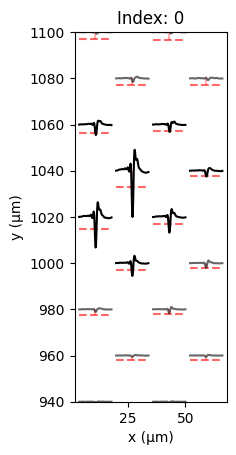

In [83]:
unit = Unit(0, spike_train, prop.prop_elecs_[0], RECORDING)
unit.plot(chans_rms=CHANS_RMS)
plt.show()

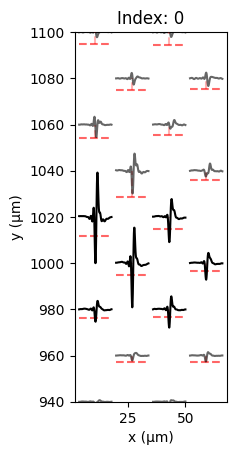

In [85]:
unit = Unit(0, prop.spike_train, prop.prop_elecs_[0], RECORDING)
unit.plot(chans_rms=CHANS_RMS)
plt.show()

  0%|          | 0/103 [00:00<?, ?it/s]

100%|██████████| 103/103 [00:26<00:00,  3.87it/s]


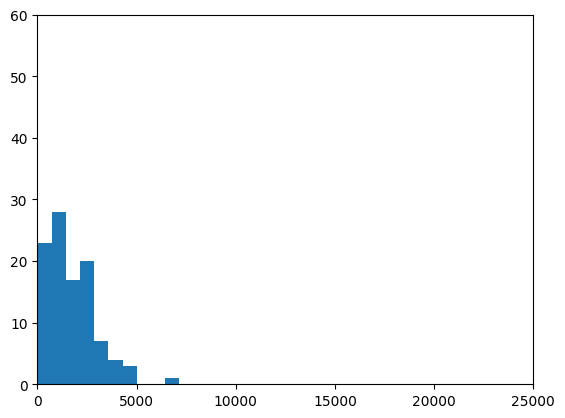

In [213]:
detect_spikes_time_frame = (5*60*1000, 10*60*1000)

all_props_detected = deepcopy(all_props)
for prop in tqdm(all_props_detected):
    spike_train = detect_spikes(prop, time_frame=detect_spikes_time_frame)
    prop.spike_train = spike_train
    
prop_signal = SpikeSorter(recording, "Prop.", [unit.spike_train for unit in all_props_detected])
plt.hist([len(p.spike_train) for p in all_props_detected])
plt.xlim(0, 25000)
plt.ylim(0, 60)
plt.show()

## Split spikes

In [207]:
# Need to set self.elecs and self.mean_amps_all for spike-splitting code to function
for prop in all_props_detected:
    prop.elecs = prop.prop_elecs_
    prop.mean_amps_all = prop.footprint_stats_[:, 4] * chans_rms

# Set mean amps across all electrodes for each unit
# num_elecs = RECORDING.get_num_channels()
# def extract_mean_amps(m_prop_idx):
#     m_prop = merged_propagations[m_prop_idx]
#     mean_amps_all = m_prop.get_mean_amps(
#         RECORDING, elecs=range(num_elecs)
#     )
#     return m_prop_idx, mean_amps_all

# from multiprocessing import Pool
# with Pool(processes=12) as pool:
#     for unit_idx, mean_amps_all in tqdm(pool.imap(extract_mean_amps, range(len(merged_propagations))), total=len(merged_propagations)):
#         merged_propagations[unit_idx].mean_amps_all = mean_amps_all

In [208]:
# IND = [0, 1]
IND = range(len(all_props_detected))
##
prop_copies = []
for idx in IND:
    unit = deepcopy(all_props_detected[idx])
    prop_copies.append(unit)
    
# F.summarize_pair_overlap(*m_prop_copies)

multi = F.split_spikes(
    prop_copies,
    CROSS_TIMES_5, CROSS_AMPS_5,
    CHANS_RMS, rms_thresh=5,
    split_overlap=0.2,
    ms_before=2/RECORDING.get_sampling_frequency(), ms_after=0.5,
    min_coactivations_n=2, min_coactivations_p=50,
    recording=RECORDING,
)

# kwargs = m_prop_copies[0].plot(RECORDING, chans_rms=CHANS_RMS)
# plt.show()

# m_prop_copies[1].plot(RECORDING, **kwargs)
# plt.show()

# F.summarize_pair_overlap(*m_prop_copies)

# kwargs = m_prop_copies[0].plot(RECORDING, chans_rms=CHANS_RMS)
# m_prop_copies[1].plot(RECORDING, **kwargs)
    
# multi.split(record_history=True)
# multi.plot_splitting(RECORDING)
# plt.show()

100%|██████████| 93487/93487 [00:11<00:00, 8475.34it/s] 


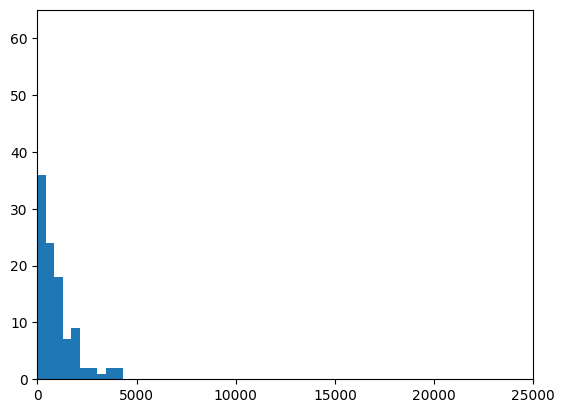

In [211]:
prop_signal = SpikeSorter(recording, "Prop.", [unit.spike_train for unit in prop_copies if len(unit.spike_train) > 0])
plt.hist([len(unit.spike_train) for unit in prop_copies])
plt.xlim(0, 25000)
plt.ylim(0, 65)
plt.show()

In [195]:
# SAVE_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/231011/spike_times.npy")
# np.save(SAVE_PATH, prop_signal.get_spike_times())

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## Comparison with kilosort

Mean: 4661.49
STD: 4321.55


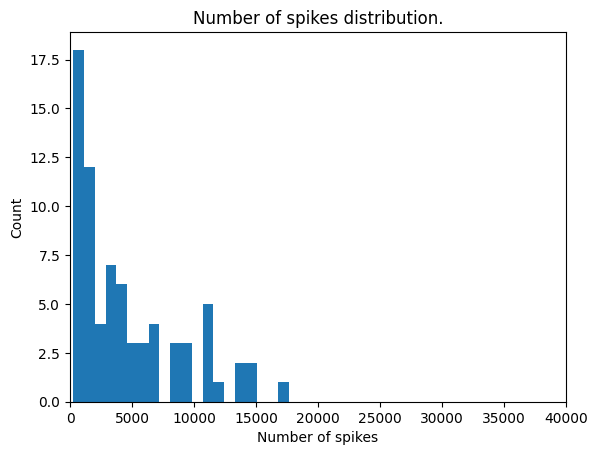

In [ ]:
props = []
props_times = []
for prop in m_prop_copies: # merged_propagations:
    props.append(prop.df)
    props_times.append(prop.spike_train)
prop_signal = PropSignal((props, props_times), RECORDING)

prop_signal.plot_nums_spikes(show=False, bins=20, range=(0, 25000))
plt.xlim(0, 25000)
plt.show()

### Just kilosort

In [85]:
"""
time_frame:
    If not None, only use coocurrences between time_frame[0]ms to time_frame[1]ms (inclusive, inclusive)
    If None, use all cooccurrences
"""

# kilosort = Kilosort(utils.PATH_SM4_SI, "first", RECORDING)
kilosort = get_experts_kilosort()
# kilosort.plot_nums_spikes(show=False, bins=20)
# plt.xlim(0, 25000)
# plt.show()

if detect_spikes_time_frame is not None:
    start_ms, end_ms = detect_spikes_time_frame
    spike_times = []
    for times in kilosort.get_spike_times():
        times_ind = start_ms <= times
        times_ind *= times <= end_ms
        spike_times.append(times[times_ind])
        
    kilosort = SpikeSorter(
        RECORDING,
        name="Experts Kilosort",
        spike_times=spike_times
    )

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/data/MEAprojects/PropSignal/src/comparison.py:335: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  warnings.warn("Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters", UserWarning)
/data/MEAprojects/PropSignal/src/sorters/kilosort.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differ

Recording does not have scaled traces. Setting gain to 0.195


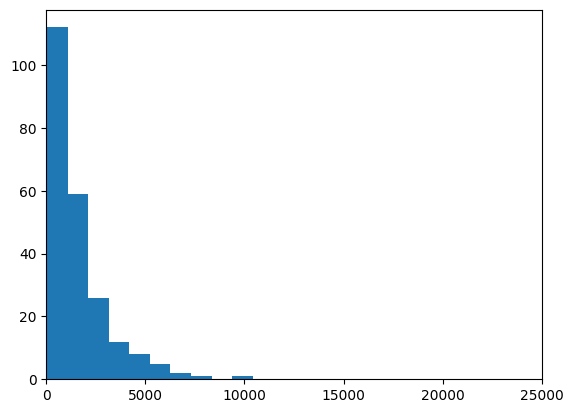

In [86]:
plt.hist([len(spike_train) for spike_train in kilosort.get_spike_times()])
plt.xlim(0, 25000)
plt.show()

Num Prop.: 103
Num Experts Kilosort: 226
Num single matches: 23

For Prop.:
Num max matches: 31
Num unique max matches: 22

For Experts Kilosort:
Num max matches: 25
Num unique max matches: 22


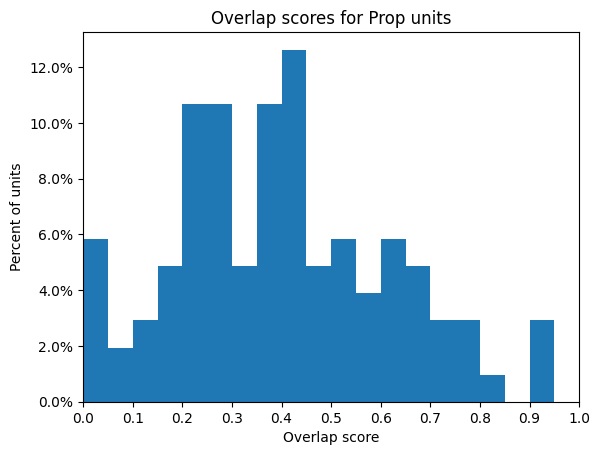

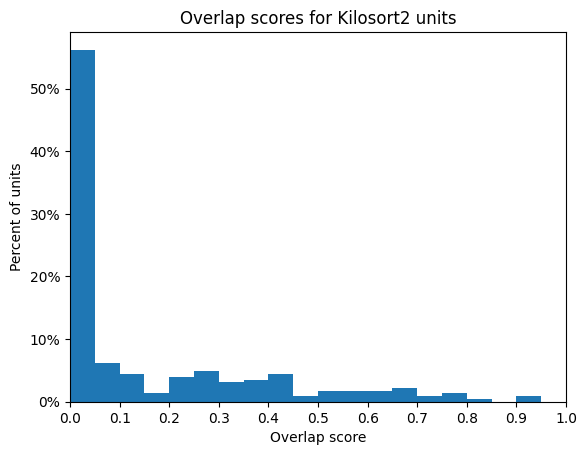

Num Prop.: 103
Num Experts Kilosort: 226
Num single matches: 49

For Prop.:
Num max matches: 71
Num unique max matches: 47

For Experts Kilosort:
Num max matches: 50
Num unique max matches: 48


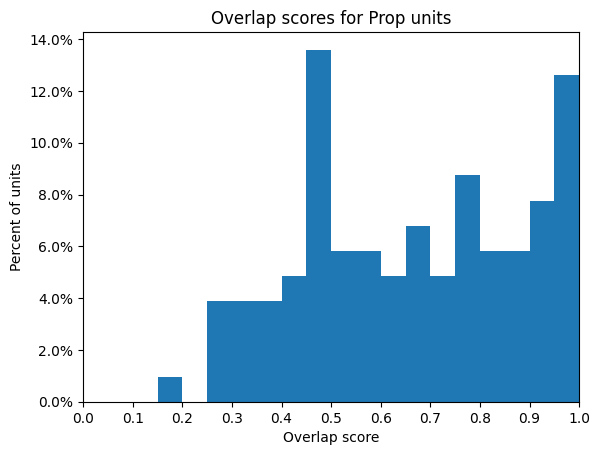

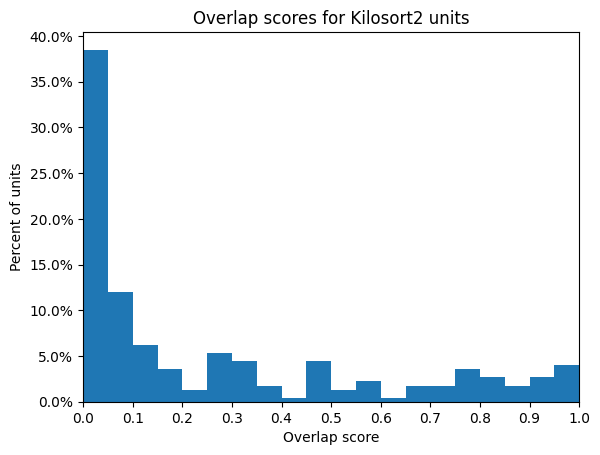

Num Prop.: 103
Num Experts Kilosort: 226
Num single matches: 57

For Prop.:
Num max matches: 68
Num unique max matches: 41

For Experts Kilosort:
Num max matches: 66
Num unique max matches: 49


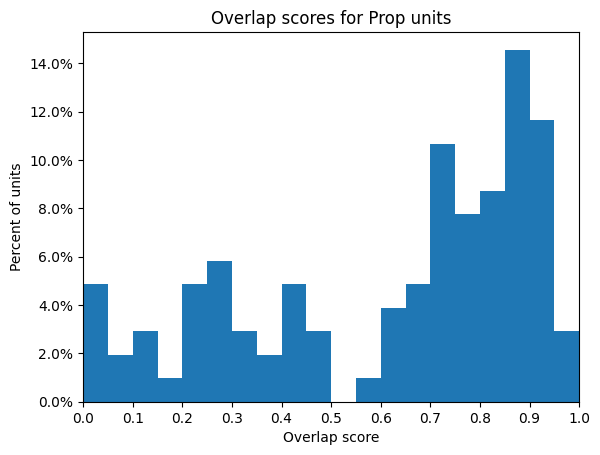

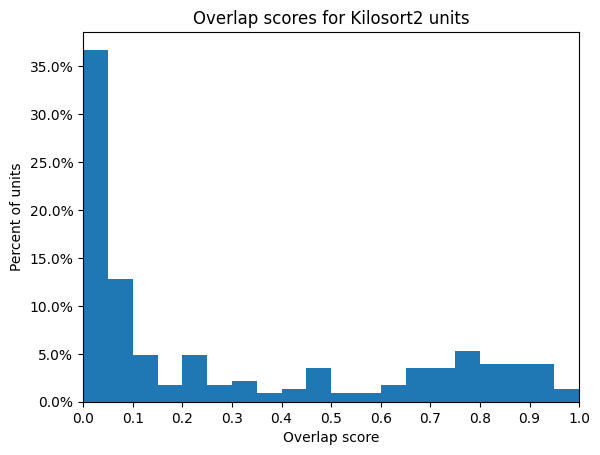

In [214]:
comp_1_5 = Comparison(prop_signal, kilosort, score_formula=1.5, delta_time=0.4)
comp_1_5.summary()

comp_1 = Comparison(prop_signal, kilosort, score_formula=1, delta_time=0.4)
comp_1.summary()

comp_2 = Comparison(prop_signal, kilosort, score_formula=2, delta_time=0.4)
comp_2.summary()

In [132]:
prop_train = set()
for spike_train in prop_signal.get_spike_times():
    prop_train.update(spike_train)
prop_train = np.sort(list(prop_train))
    
ks_train = set()
for spike_train in kilosort.get_spike_times():
    ks_train.update(spike_train)
ks_train = np.sort(list(ks_train))

num_matches = Comparison.count_matching_events(prop_train, ks_train,
                                               delta=0.4)
print(f"#spikes:")
print(f"Matches: {num_matches}")
print(f"Prop: {len(prop_train)}, {num_matches/len(prop_train)*100:.1f}")
print(f"Kilosort: {len(ks_train)}, {num_matches/len(ks_train)*100:.1f}")

#spikes:
Matches: 100622
Prop: 110035, 91.4
Kilosort: 347992, 28.9


### Kilosort as prop
Assume each kilosort unit is a root that needs to be merged with other roots and detects spikes

In [181]:
# Form ks_prop units and set footprint stats for MERGING (use_rms_thresh=FALSE)

class KSProp:
    def __init__(self, spike_train) -> None:
        self.spike_train = spike_train
        
def form_ks_prop(spike_train):
    prop = KSProp(spike_train)
    set_footprint_stats(prop, use_rms_thresh=True, rel_amp_thresh=0)  # Should be false
    return prop

all_ks_props = []
with Pool(processes=20) as pool:
    kilosort_spike_times = kilosort.get_spike_times()
    for ks_prop in tqdm(pool.imap(form_ks_prop, kilosort_spike_times), total=len(kilosort_spike_times)):
        all_ks_props.append(ks_prop)

100%|██████████| 226/226 [01:49<00:00,  2.06it/s]


In [94]:
# Look at footprint stats
for elec in all_ks_props[1].prop_elecs_:
    print(elec, [round(s, 4) for s in all_ks_props[1].footprint_stats_[elec]])

1 [0.0229, 0.0483, 2.3026, 0.5224, 5.2879]


In [176]:
# Merge - intraGMM
elec_to_ks = {}
for ks in all_ks_props:
    # print(ks.prop_elecs_)
    
    if len(ks.prop_elecs_) > 0:
        # print(np.sort(ks.footprint_stats_[:, -1])[-3:])
        # unit = Unit(0, ks.spike_train, np.argmax(ks.footprint_stats_[:, 2]), recording)
        # unit.plot(chans_rms=chans_rms)
        # plt.show()
        
        elec = ks.prop_elecs_[0]
        if elec not in elec_to_ks:
            elec_to_ks[elec] = [ks]
        else:
            elec_to_ks[elec].append(ks)
            
all_ks_props_merged = []
for ks_props in tqdm(elec_to_ks.values()):
    if len(ks_props) == 1:
        all_ks_props_merged += ks_props
    else:
        all_ks_props_merged += merge_roots(deepcopy(ks_props))
        
# Set self.recording=None so units can be pickled
all_ks_props = []
for ks_prop in all_ks_props_merged:
    ks_prop.recording=None
    all_ks_props.append(ks_prop)
print(f"#merges: {len(all_ks_props)}")

100%|██████████| 120/120 [00:00<00:00, 1301.74it/s]

#merges: 160


In [177]:
# Form ks_prop units and set footprint stats for DETECTING SPIKES (use_rms_thresh=TRUE)        
def job(ks_prop):
    set_footprint_stats(ks_prop, use_rms_thresh=True)
    return ks_prop

all_ks_props_spikes = []
with Pool(processes=20) as pool:
    for ks_prop in tqdm(pool.imap(job, all_ks_props), total=len(all_ks_props)):
        all_ks_props_spikes.append(ks_prop)
all_ks_props = all_ks_props_spikes

  0%|          | 0/160 [00:00<?, ?it/s]

100%|██████████| 160/160 [01:18<00:00,  2.04it/s]


In [ ]:
# Check footprints of kilosort units
kilosort_15 = get_experts_kilosort()

for i, spike_train in enumerate(kilosort_15.get_spike_times()):    
    unit = Unit(i, spike_train, 0, recording)
    unit.set_templates(num_wfs=500)
    unit.chan = np.argmin(np.min(unit.templates, axis=1))
    unit.plot(chans_rms=chans_rms)
    plt.show()

In [178]:
# Detect spikes
ks_prop_spike_times = []
for ks in tqdm(all_ks_props):
    if len(ks.prop_elecs_) > 1:
        spikes = detect_spikes(ks, x_std=1000, min_coc_p=0)
        if len(spikes) > 0:
            ks_prop_spike_times.append(spikes)

  7%|▋         | 11/160 [00:00<00:04, 31.63it/s]

100%|██████████| 160/160 [00:05<00:00, 26.84it/s]


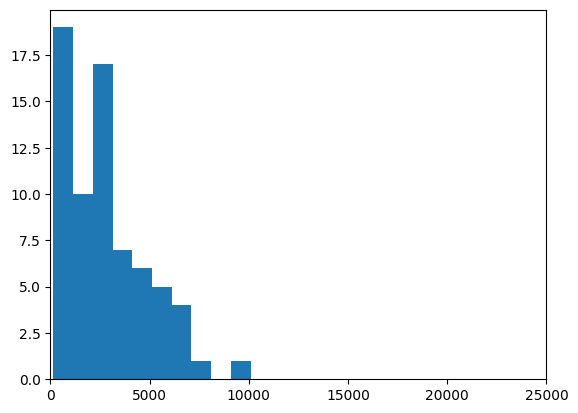

In [179]:
kilosort_prop = DummySorter(ks_prop_spike_times, name="Kilosort Prop")
plt.hist([len(k) for k in ks_prop_spike_times])
plt.xlim(0, 25000)
plt.show()

/data/MEAprojects/PropSignal/src/comparison.py:335: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  warnings.warn("Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters", UserWarning)


Num Prop: 104
Num Kilosort Prop: 70
Num single matches: 32

For Prop:
Num max matches: 34
Num unique max matches: 32

For Kilosort Prop:
Num max matches: 40
Num unique max matches: 31


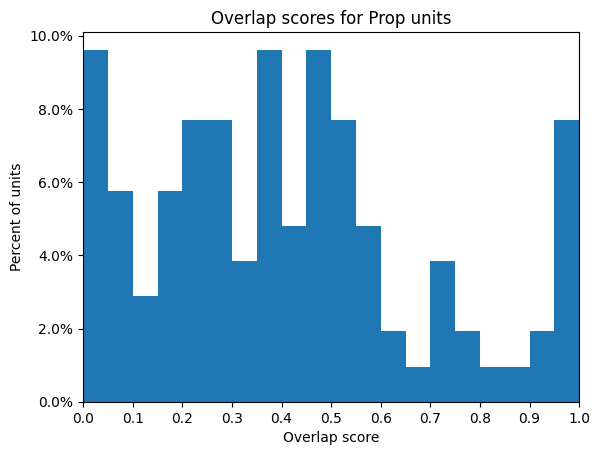

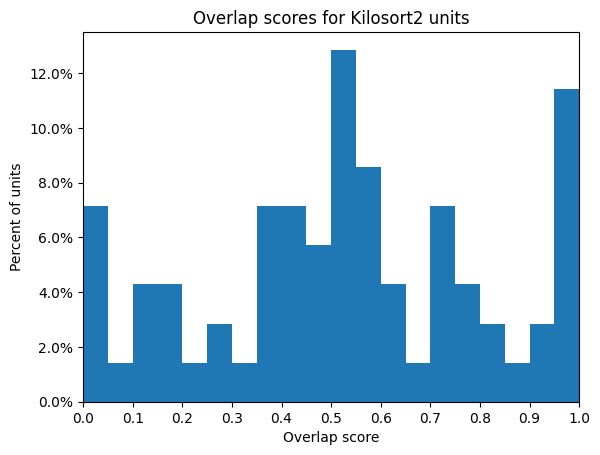

Num Prop: 104
Num Kilosort Prop: 70
Num single matches: 55

For Prop:
Num max matches: 79
Num unique max matches: 47

For Kilosort Prop:
Num max matches: 57
Num unique max matches: 46


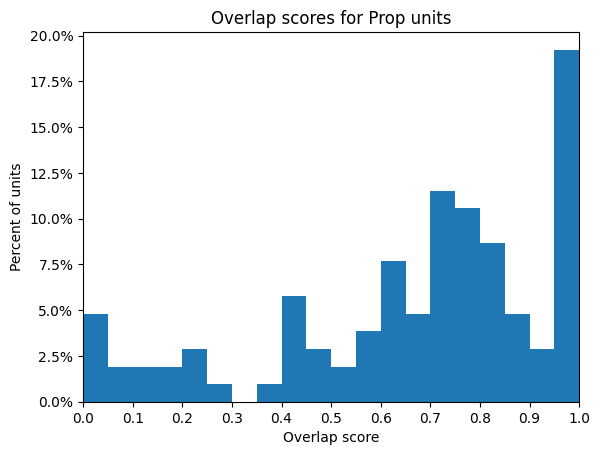

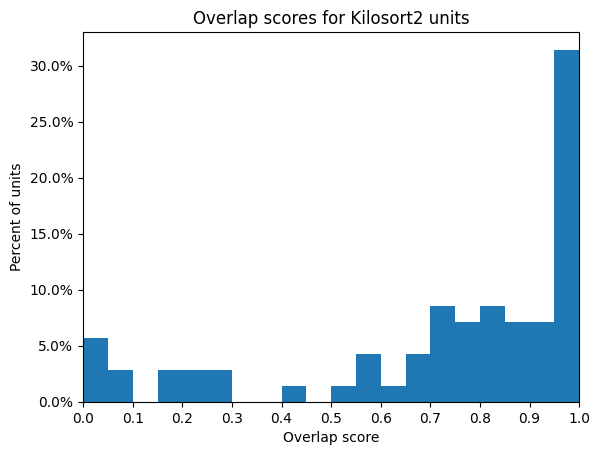

Num Prop: 104
Num Kilosort Prop: 70
Num single matches: 41

For Prop:
Num max matches: 48
Num unique max matches: 35

For Kilosort Prop:
Num max matches: 51
Num unique max matches: 34


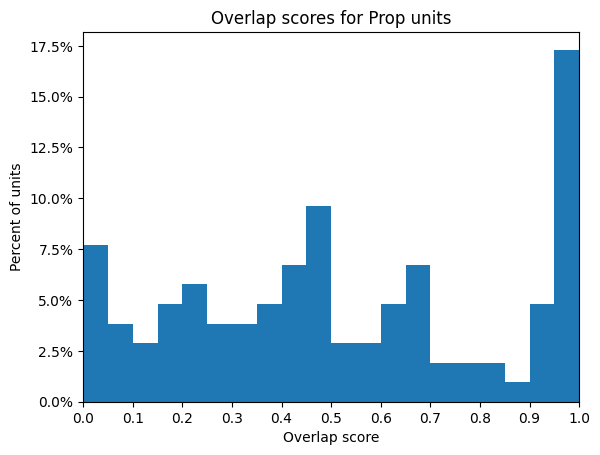

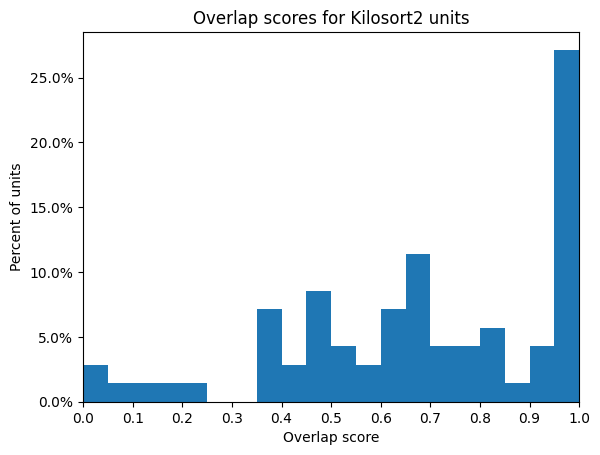

In [180]:
comp_1_5 = Comparison(prop_signal, kilosort_prop, score_formula=1.5)
comp_1_5.summary()

comp_1 = Comparison(prop_signal, kilosort_prop, score_formula=1)
comp_1.summary()

comp_2 = Comparison(prop_signal, kilosort_prop, score_formula=2)
comp_2.summary()

### Merged kilosort

In [200]:
# Extract mean templates for prop units

NUM_WFS = 300
MS_BEFORE = 2
MS_AFTER = 2

np.random.seed(231)
##
# Need to convert prop's units from Unit objects to PropUnit objects
prop_units = []
for idx, unit in enumerate(prop_signal):
    dataframe = []
    for elec in all_props_detected[idx].prop_elecs_:
        dataframe.append((elec, all_props_detected[idx].footprint_stats_[elec, 0], 100, 1))
    dataframe = DataFrame(dataframe, columns=["ID", "latency", "cooccurrences", "ccg_ratio"])
    dataframe = dataframe.astype({"ID": int, "latency": float, "cooccurrences": int, "ccg_ratio": float})
    prop_units.append(PropUnit([dataframe], idx, spike_train=unit.spike_train, recording=RECORDING))

def extract_templates(unit_idx):
    unit = prop_units[unit_idx]
    return unit_idx, unit.get_templates(num_wfs=NUM_WFS, ms_before=MS_BEFORE, ms_after=MS_AFTER)

with Pool(processes=12) as pool:
    for unit_idx, templates in tqdm(pool.imap(extract_templates, range(len(prop_units))), total=len(prop_units)):
        prop_units[unit_idx].templates = templates
        prop_units[unit_idx].chan = np.argmin(np.min(templates, axis=1))

100%|██████████| 103/103 [00:39<00:00,  2.60it/s]


In [139]:
# Extract mean templates for kilosort units

NUM_WFS = 300
MS_BEFORE = 2
MS_AFTER = 2

np.random.seed(231)
##
ks_units = [unit for unit in kilosort]
def extract_templates(unit_idx):
    unit = ks_units[unit_idx]
    return unit_idx, unit.get_templates(num_wfs=NUM_WFS, ms_before=MS_BEFORE, ms_after=MS_AFTER)

with Pool(processes=12) as pool:
    for unit_idx, templates in tqdm(pool.imap(extract_templates, range(len(ks_units))), total=len(ks_units)):
        ks_units[unit_idx].templates = templates
        ks_units[unit_idx].chan = np.argmin(np.min(templates, axis=1))

100%|██████████| 226/226 [01:21<00:00,  2.78it/s]


In [201]:
F.grid_search_num_merges(prop_units, ks_units, comp_2.agreement_scores, 
                         max_isi_viol_p_values=[None, 1, 1.5, 2, 3, 4, 5], max_wf_diff_values=[100, 200, 300, 400, 500, 600, 700])

,100,200,300,400,500,600,700
NaN,0,0,0,0,0,0,0
1.0,0,6,16,18,18,18,18
1.5,0,6,16,18,18,18,18
2.0,0,8,18,20,20,20,20
3.0,0,9,19,21,21,21,21
4.0,0,11,21,23,23,23,23
5.0,0,11,21,23,23,23,23


In [202]:
merged_ks_units = F.merge_ks_units(prop_units, ks_units, comp_2.agreement_scores,
                                   max_isi_viol_p=1, max_wf_diff=400)
sum(len(merge) for merge in merged_ks_units if len(merge) > 1)
# test = [merge for merge in merged_ks_units if len(merge) > 1]

18

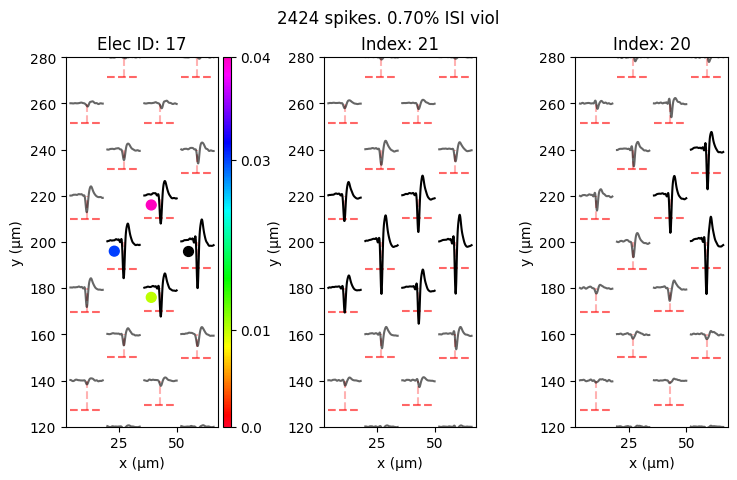

% ISI violations for each unit


21,20
0.0,0.0



Waveform dissimilarity for each unit pair


,21,20
21,-1,187
20,-1,-1


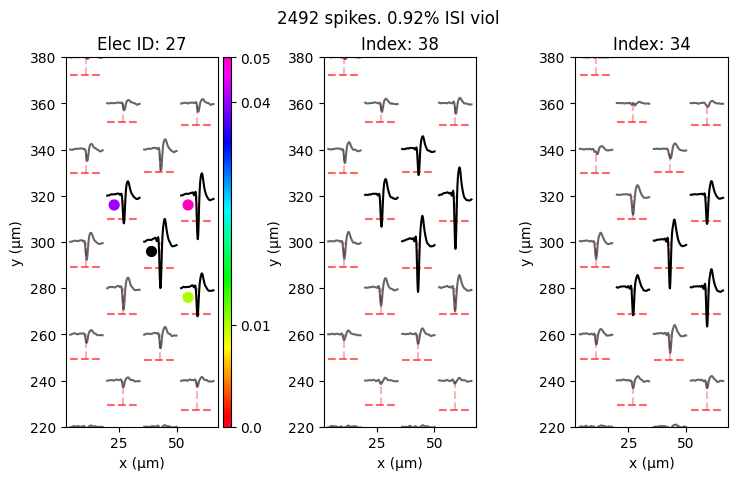

% ISI violations for each unit


38,34
0.06,0.0



Waveform dissimilarity for each unit pair


,38,34
38,-1,177
34,-1,-1


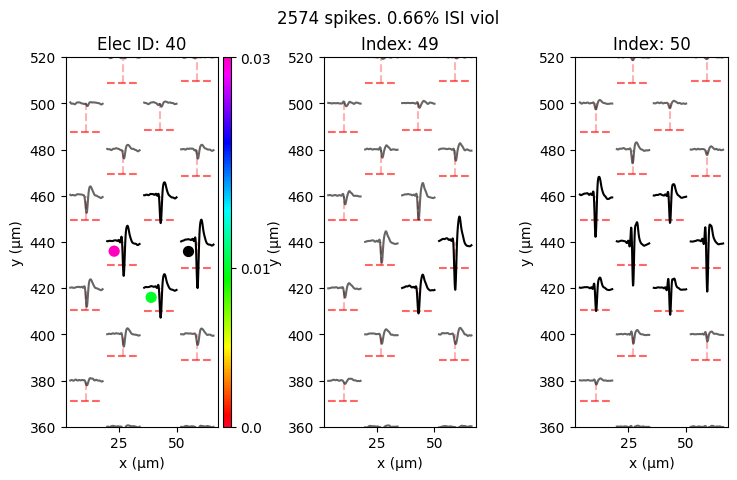

% ISI violations for each unit


49,50
0.0,0.0



Waveform dissimilarity for each unit pair


,49,50
49,-1,219
50,-1,-1


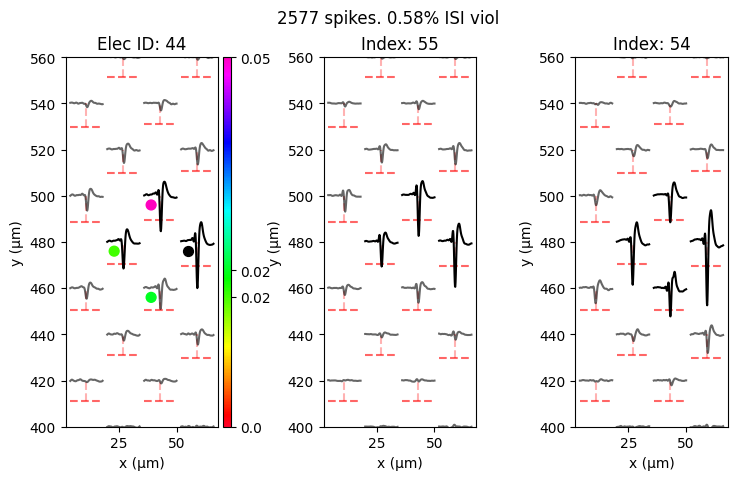

% ISI violations for each unit


55,54
0.0,0.0



Waveform dissimilarity for each unit pair


,55,54
55,-1,175
54,-1,-1


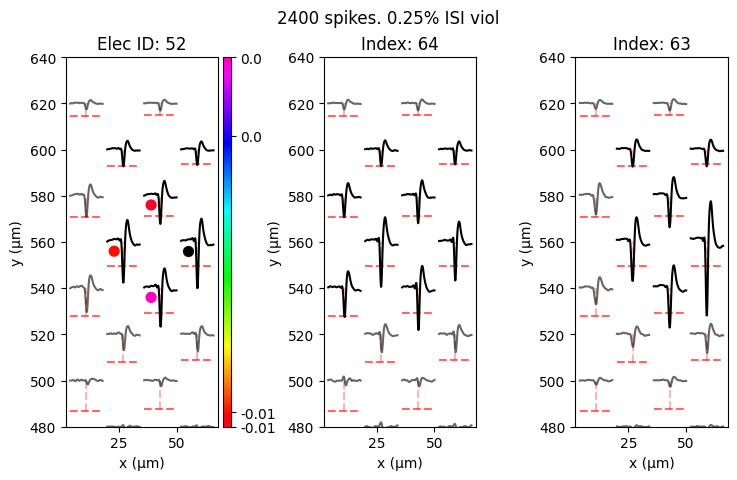

% ISI violations for each unit


64,63
0.0,0.0



Waveform dissimilarity for each unit pair


,64,63
64,-1,207
63,-1,-1


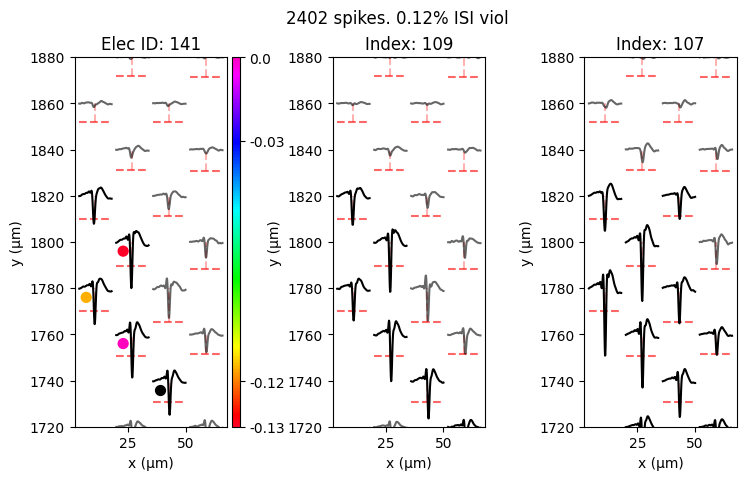

% ISI violations for each unit


109,107
0.0,0.0



Waveform dissimilarity for each unit pair


,109,107
109,-1,192
107,-1,-1


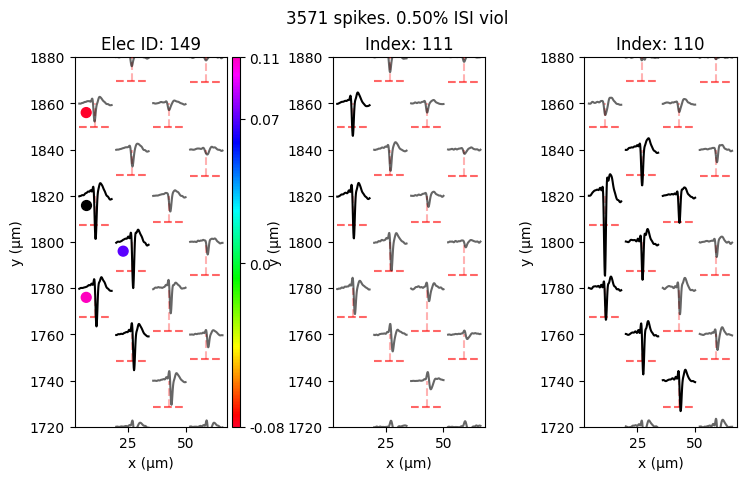

% ISI violations for each unit


111,110
0.03,0.0



Waveform dissimilarity for each unit pair


,111,110
111,-1,277
110,-1,-1


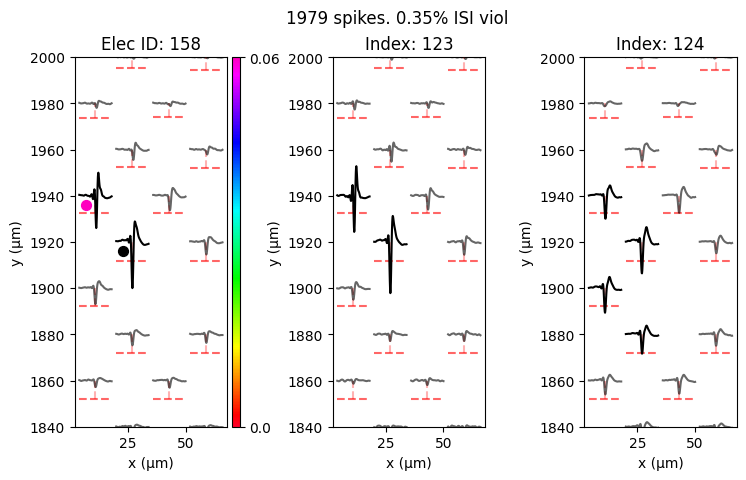

% ISI violations for each unit


123,124
0.0,0.15



Waveform dissimilarity for each unit pair


,123,124
123,-1,300
124,-1,-1


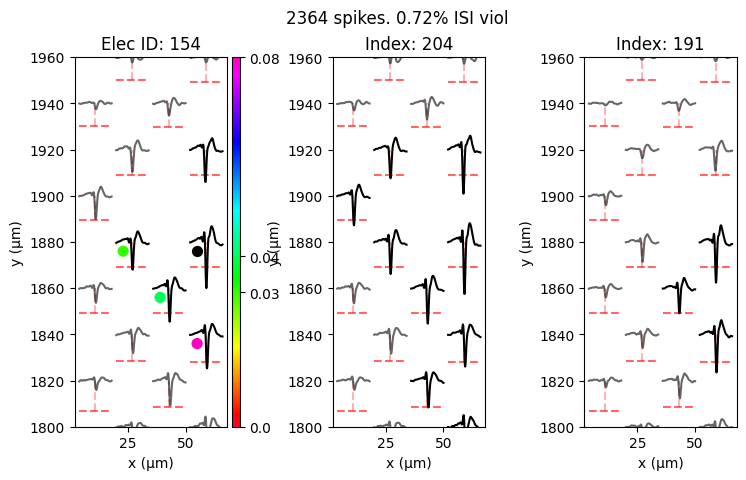

% ISI violations for each unit


204,191
0.0,0.22



Waveform dissimilarity for each unit pair


,204,191
204,-1,266
191,-1,-1


In [173]:
for merge in merged_ks_units:
    if len(merge) > 1:
        merge.plot(CHANS_RMS)

/data/MEAprojects/PropSignal/src/comparison.py:335: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  warnings.warn("Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters", UserWarning)


Num Prop.: 103
Num Sorter: 217
Num single matches: 26

For Prop.:
Num max matches: 37
Num unique max matches: 25

For Sorter:
Num max matches: 28
Num unique max matches: 25


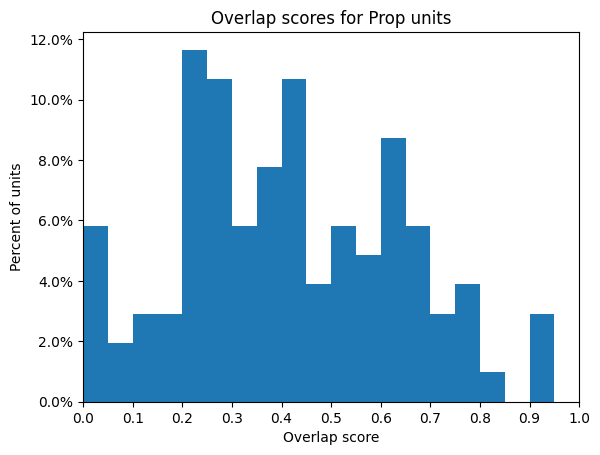

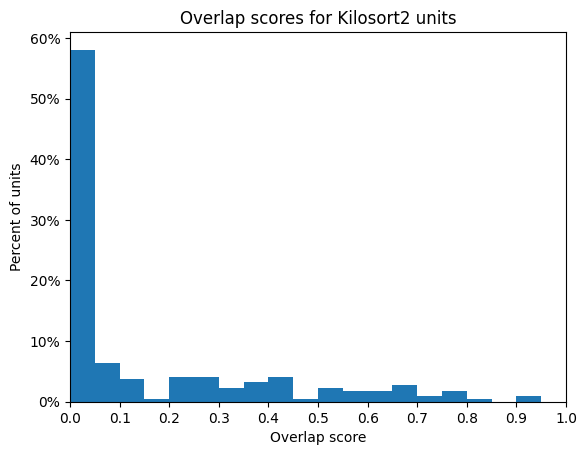

Num Prop.: 103
Num Sorter: 217
Num single matches: 52

For Prop.:
Num max matches: 81
Num unique max matches: 50

For Sorter:
Num max matches: 53
Num unique max matches: 51


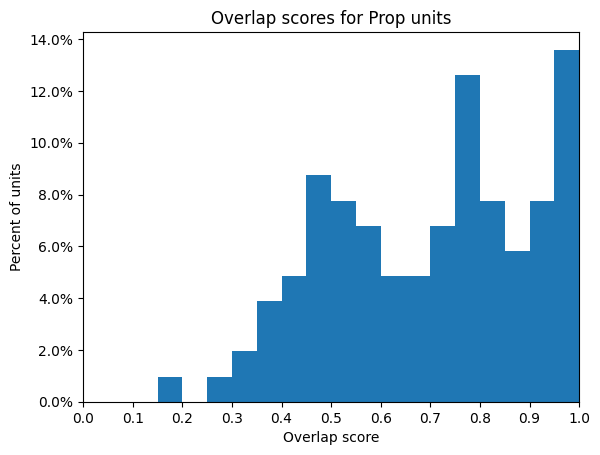

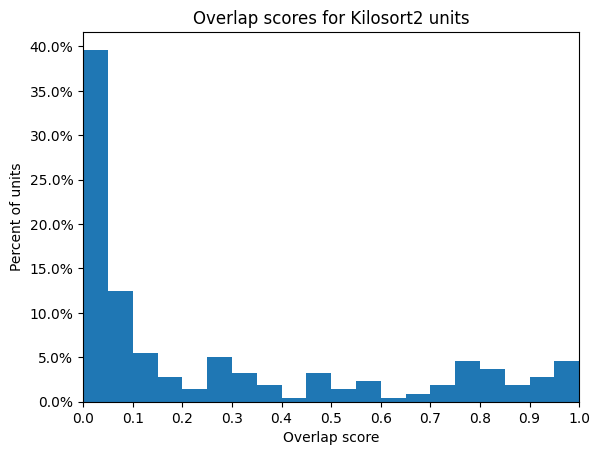

Num Prop.: 103
Num Sorter: 217
Num single matches: 54

For Prop.:
Num max matches: 68
Num unique max matches: 43

For Sorter:
Num max matches: 57
Num unique max matches: 49


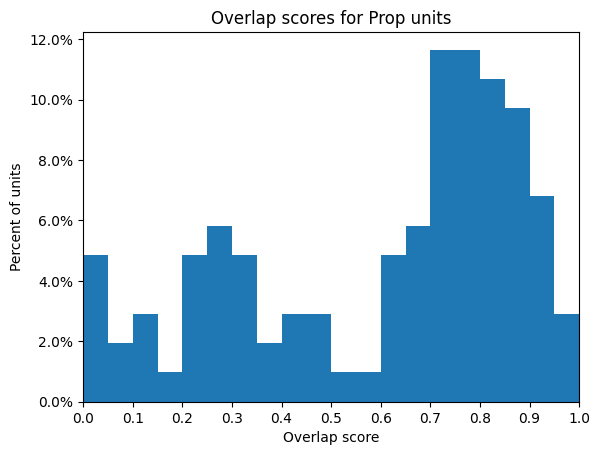

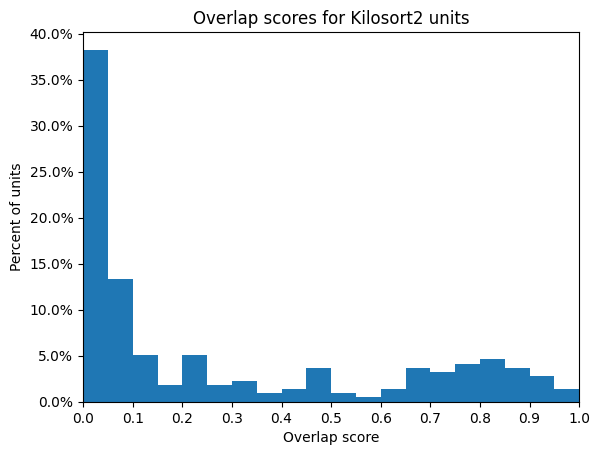

Change Prop to Prop + DL if necessay


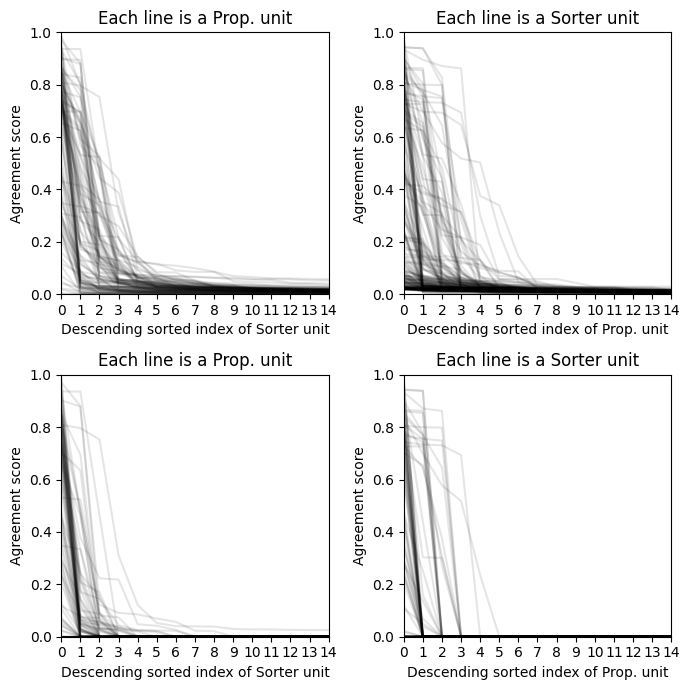

In [203]:
kilosort_dummy = DummySorter.units_to_sorter(merged_ks_units, name="Kilosort2")
_ = Comparison.full(prop_signal, kilosort_dummy)

### Only prop spikes within kilosort spikes

In [204]:
within_prop_units, outside_prop_units = F.select_prop_spikes_within_kilosort_spikes(prop_units, merged_ks_units, RECORDING,
                                                                                    max_ms_dist=0.4, max_micron_dist=200)

4.9%


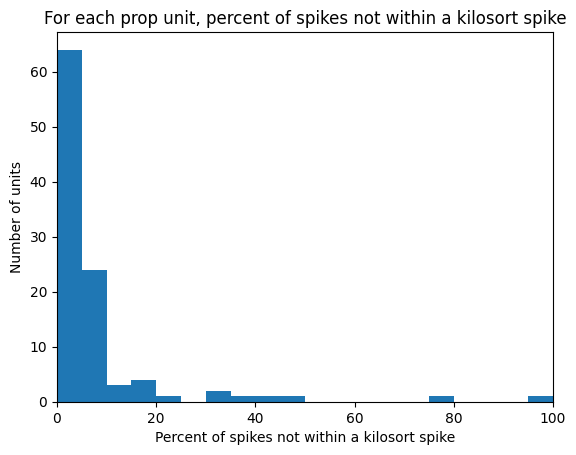

In [205]:
outside_percents = []
total_within = 0
total_outside = 0
for within, outside in zip(within_prop_units, outside_prop_units):
    within, outside = len(within.spike_train), len(outside.spike_train)
    total_within += within
    total_outside += outside
    outside_percents.append(outside / (outside+within) * 100)

print(f"{total_outside/(total_within + total_outside)*100:.1f}%")
plot.hist(outside_percents, xlim=(0, 100), bins=20)
plt.title("For each prop unit, percent of spikes not within a kilosort spike")
plt.xlabel("Percent of spikes not within a kilosort spike")
plt.ylabel("Number of units")
plt.show()

In [ ]:
for within, outside, outside_percent in zip(within_prop_units, outside_prop_units, outside_percents):
    # if outside_percent < 20:
    #     continue
    
    fig, axes = plt.subplots(1, 2, figsize=(7.2, 4.8))
    kwargs = within.plot(subplot=(fig, axes[0]), chans_rms=CHANS_RMS)
    fig.suptitle(axes[0].get_title())
    axes[0].set_title(f"{len(within.spike_train)} within spikes")
    outside.plot(subplot=(fig, axes[1]), **kwargs)
    axes[1].set_title(f"{len(outside.spike_train)} outside spikes")
    print(f"{outside_percent:.1f}% percent of spikes not within a kilosort spike")
    plt.show()

4.0% percent of spikes not within a kilosort spike


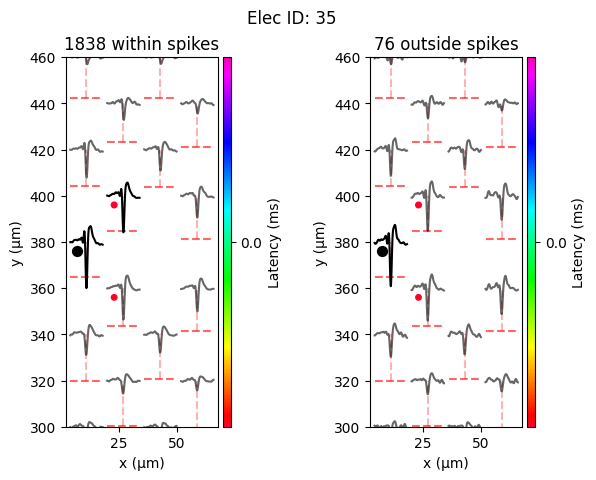

In [ ]:
# Look at a specific example
# IDX = 12
# within, outside, outside_percent = within_prop_units[IDX], outside_prop_units[IDX], outside_percents[IDX]

# fig, axes = plt.subplots(1, 2, figsize=(7.2, 4.8))
# kwargs = within.plot(subplot=(fig, axes[0]), chans_rms=CHANS_RMS)
# fig.suptitle(axes[0].get_title())
# axes[0].set_title(f"{len(within.spike_train)} within spikes")
# outside.plot(subplot=(fig, axes[1]), **kwargs)
# axes[1].set_title(f"{len(outside.spike_train)} outside spikes")
# print(f"{outside_percent:.1f}% percent of spikes not within a kilosort spike")
# plt.show()

/data/MEAprojects/PropSignal/src/comparison.py:335: UserWarning: Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters
  warnings.warn("Using Comparison.count_matching_events_si which is inaccurate when many spikes in succession match between the two sorters", UserWarning)


Num Sorter: 102
Num Sorter: 217
Num single matches: 26

For Sorter:
Num max matches: 37
Num unique max matches: 25

For Sorter:
Num max matches: 28
Num unique max matches: 25


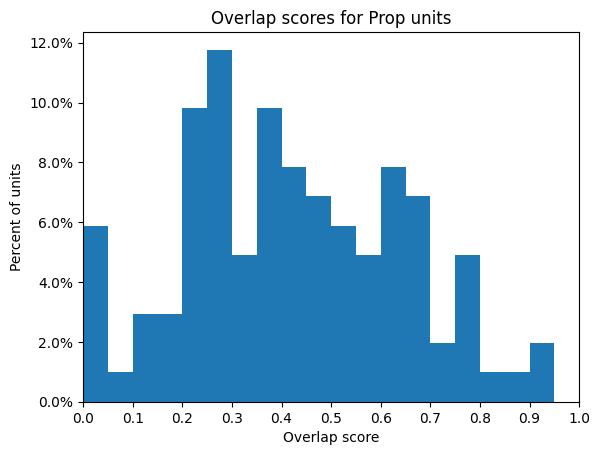

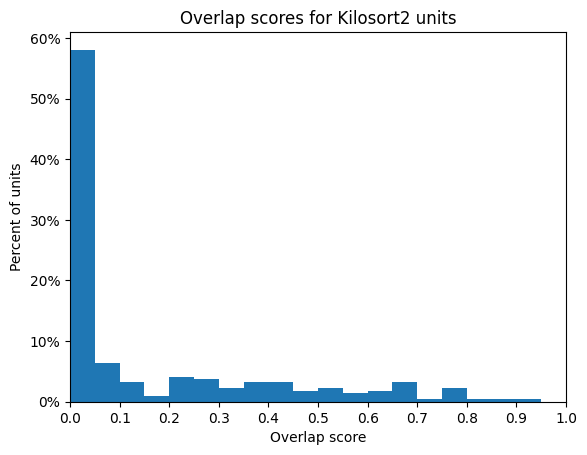

Num Sorter: 102
Num Sorter: 217
Num single matches: 55

For Sorter:
Num max matches: 86
Num unique max matches: 53

For Sorter:
Num max matches: 57
Num unique max matches: 52


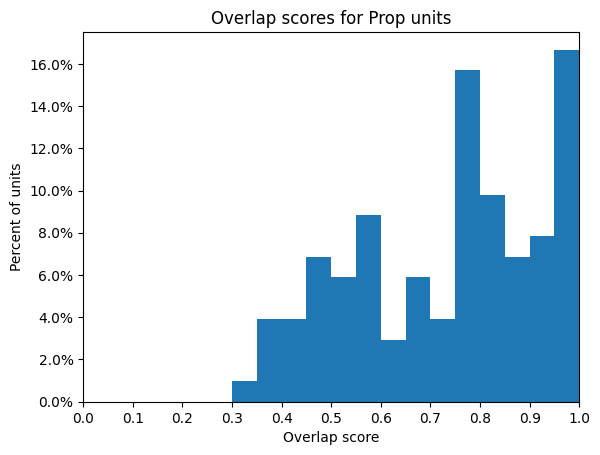

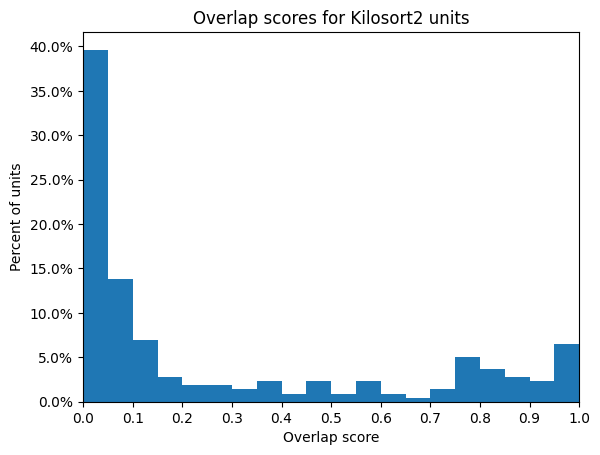

Num Sorter: 102
Num Sorter: 217
Num single matches: 54

For Sorter:
Num max matches: 68
Num unique max matches: 43

For Sorter:
Num max matches: 57
Num unique max matches: 47


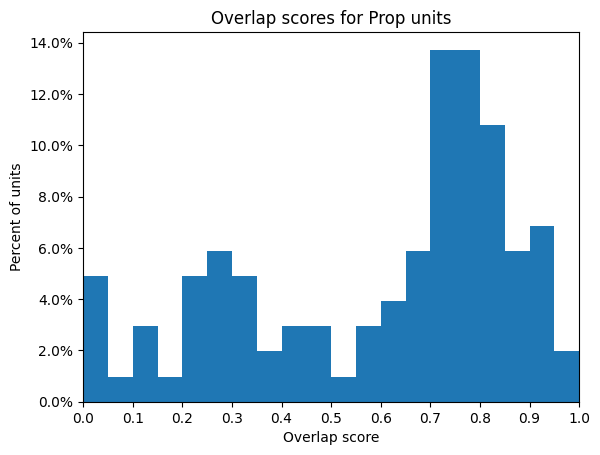

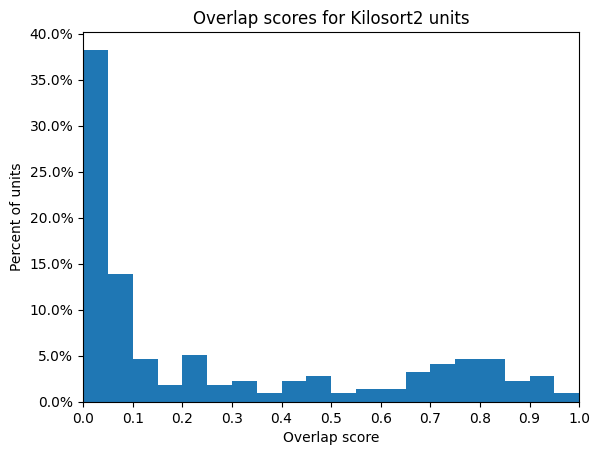

Change Prop to Prop + DL if necessay


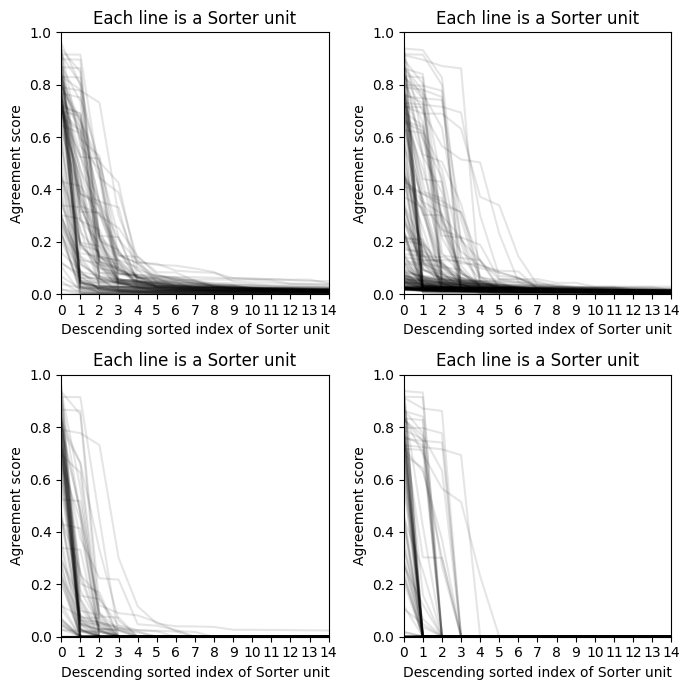

In [206]:
prop_dummy = DummySorter.units_to_sorter([unit for unit in within_prop_units if len(unit.spike_train) > 0], name="Prop.")
_ = Comparison.full(prop_dummy, kilosort_dummy)